# COVID severity analysis on PAC design

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
import diff2atlas

Global seed set to 0


In [4]:
figdir = resdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/COVID_analysis_severity/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [5]:
sc.settings.figdir = figdir

In [6]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [7]:
%load_ext rpy2.ipython

In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

plotting utils

In [9]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [10]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

## Load preprocessed dataset

Generated in `20220713_COVID_design.ipynb`

In [16]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata = milopy.utils.read_milo_adata(filepath=data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')

In [17]:
adata.uns['nhood_neighbors_key'] = None

In [18]:
## Group annotations
all_annos = adata.obs['author_cell_type'].unique().tolist()
anno_groups = {}

## NKt
anno_groups['CD4 T'] = [x for x in all_annos if x.startswith("CD4.")]
anno_groups['CD8 T'] = [x for x in all_annos if x.startswith("CD8.")]
anno_groups['unconv T'] = ['MAIT', 'NKT', 'gdT', 'Treg']
anno_groups['NK'] = [x for x in all_annos if x.startswith("NK_")]
anno_groups['ILC'] = [x for x in all_annos if x.startswith("ILC")]

## B cells
anno_groups['B cells'] = [x for x in all_annos if x.startswith("B_")]
anno_groups['plasma'] = [x for x in all_annos if x.startswith("Plasma_cell")] + ['Plasmablast']

## blood cells
anno_groups['HSPC'] = [x for x in all_annos if x.startswith("HSC_")]
anno_groups['ery/mk'] = ['Platelets', 'RBC']

## Myeloid
anno_groups['DC'] = [x for x in all_annos if x.startswith("DC")] + ["ASDC", 'pDC']
anno_groups['monos'] = [x for x in all_annos if x not in sum(anno_groups.values(), [])]

anno_group_rev = {x:k for k,v in anno_groups.items() for x in v}
anno_group_order = anno_groups.keys()

## Run Milo analysis on severity

In [183]:
## Convert severity to continuous variable
order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
adata.obs['severity_cont'] = adata.obs['Status_on_day_collection_summary'].copy()
## turn LPS treatment to nan
adata.obs['severity_cont'] = np.where(adata.obs['severity_cont'].isin(order_severity), adata.obs['severity_cont'], np.nan)
adata.obs['severity_cont'] = adata.obs['severity_cont'].astype("category")
adata.obs['severity_cont'] = adata.obs['severity_cont'].cat.reorder_categories(order_severity).cat.codes

milopy.utils.add_covariate_to_nhoods_var(adata, ['severity_cont'])

In [15]:
# milopy.core.DA_nhoods(adata, design = '~ Site + severity_DA', model_contrasts = 'severity_DAAsymptomatic-severity_DAHealthy')
# adata.uns['nhood_adata'].obs[f'logFC_asymp'] = adata.uns['nhood_adata'].obs['logFC'].copy()
# adata.uns['nhood_adata'].obs[f'SpatialFDR_asymp'] = adata.uns['nhood_adata'].obs['SpatialFDR'].copy()

In [16]:
for i,sev in enumerate(order_severity):
    if i > 0:
        print(f"DA test - {sev}")
        milopy.utils.add_covariate_to_nhoods_var(adata, ['severity_cont'])
        adata.uns['nhood_adata'].var['severity_cont'] = adata.uns['nhood_adata'].var['severity_cont'].astype('int')
        
        exclude_lps = adata.uns['nhood_adata'].var['severity_cont'] >= 0
        keep_samples = adata.uns['nhood_adata'].var_names[exclude_lps & (adata.uns['nhood_adata'].var['severity_cont'] <= i)]
        milopy.core.DA_nhoods(adata, design = '~ Site + severity_cont', 
                              subset_samples=keep_samples)
        adata.uns['nhood_adata'].obs[f'logFC_{sev}'] = adata.uns['nhood_adata'].obs['logFC'].copy()
        adata.uns['nhood_adata'].obs[f'SpatialFDR_{sev}'] = adata.uns['nhood_adata'].obs['SpatialFDR'].copy()

DA test - Asymptomatic
DA test - Mild
DA test - Moderate
DA test - Severe
DA test - Critical


### Save results 

In [17]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs

index_cell  kth_distance  \
0     10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1      0.882193   
1     10_1038_s41591_021_01329_2-S11_CGGTTAATCGGATGGA-1      0.713938   
2     10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1      0.898555   
3     10_1038_s41591_021_01329_2-S11_CTTCTCTGTACTTAGC-1      0.768485   
4     10_1038_s41591_021_01329_2-S12_CGGACACTCAGCTTAG-1      0.629925   
...                                                 ...           ...   
4784  10_1038_s41591_021_01329_2-TAGCCGGCAACACGCC-ne...      0.871801   
4785  10_1038_s41591_021_01329_2-GCATGTAAGCTTATCG-ne...      0.682758   
4786  10_1038_s41591_021_01329_2-GTGCAGCAGTGTGGCA-ne...      1.165385   
4787  10_1038_s41591_021_01329_2-GCGCGATTCAAGAAGT-ne...      1.026302   
4788  10_1038_s41591_021_01329_2-CACAGGCCAAGCCATT-ne...      0.794229   

     nhood_annotation  nhood_annotation_frac  SpatialFDR  nhood_IFN_signature  \
0             NK_16hi               0.982558    0.415595            -0.002200   
1           CD8.Naive               0.428571    0.092539            -0.065815   
2             B_naive               0.370968    0.941939            -0.075459   
3              CD4.CM               0.523810    0.713165            -0.067536   
4              CD4.CM               0.750000    0.860194            -0.140777   
...               ...                    ...         ...                  ...   
4784           CD8.TE               0.532258    0.558459            -0.005379   
4785           CD4.CM               0.419512    0.350666            -0.071640   
4786              gdT               0.561151    0.065422            -0.049021   
4787          NK_16hi               0.683871    0.692801             0.034771   
4788        Platelets               1.000000    0.057066            -0.083112   

      logFC_Asymptomatic  SpatialFDR_Asymptomatic  logFC_Mild  \
0               0.157223                 0.973210   -0.332594   
1              -0.617565                 0.826834    0.057872   
2              -0.147530                 0.977665   -0.070021   
3              -0.341551                 0.942384    0.151110   
4              -0.511469                 0.876407   -0.749319   
...                  ...                      ...         ...   
4784            0.086097                 0.986249    0.261010   
4785           -0.732103                 0.789819   -0.166028   
4786            0.240014                 0.963522   -0.147145   
4787           -1.617502                 0.362390   -0.433773   
4788           -0.228854                 0.970651    0.670608   

      SpatialFDR_Mild  ...  SpatialFDR_Moderate  logFC_Severe  \
0            0.454460  ...             0.471969     -0.161176   
1            0.924706  ...             0.721263     -0.174537   
2            0.916344  ...             0.649906     -0.103232   
3            0.773942  ...             0.969858      0.012108   
4            0.033948  ...             0.847912     -0.132964   
...               ...  ...                  ...           ...   
4784         0.601607  ...             0.469308      0.136616   
4785         0.732574  ...             0.314714     -0.194171   
4786         0.799281  ...             0.078711     -0.276968   
4787         0.298138  ...             0.546274     -0.071600   
4788         0.129675  ...             0.716469      0.330013   

      SpatialFDR_Severe     logFC    logCPM         F    PValue       FDR  \
0              0.424592 -0.130734  8.862654  1.894709  0.170013  0.398919   
1              0.395694 -0.239716  9.022122  5.887983  0.016016  0.083371   
2              0.674878  0.019103  8.880465  0.037489  0.846645  0.938440   
3              0.970125  0.074012  8.908513  0.565868  0.452677  0.701341   
4              0.577003 -0.047052  8.903845  0.166776  0.683374  0.852927   
...                 ...       ...       ...       ...       ...       ...   
4784           0.553928  0.107893  8.875025  1.137986  0.287199  0.542135   
4785           0.

In [18]:
nhood_adata.write_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.nhood_adata.severity.h5ad')

In [19]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
nhood_adata = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.nhood_adata.severity.h5ad')

In [20]:
order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]

## Compare results across all nhoods

logFC_Asymptomatic  logFC_Mild  logFC_Moderate  logFC_Severe  \
0              -0.643331    1.365259        0.908265      0.785217   
1               0.771672    1.257700        0.840087      0.711407   
2               0.142558    0.930505        0.703720      0.465286   
3               1.135137    0.333982        0.499920      0.027060   
4               0.576815    0.388620        0.049313     -0.373632   
...                  ...         ...             ...           ...   
1628           -1.700730   -1.535745       -1.412362     -1.326208   
1629           -1.485686   -1.767079       -1.491987     -1.405349   
1630           -1.543066   -1.853977       -1.295473     -1.702468   
1631           -1.699038   -2.071097       -1.375262     -1.318493   
1632           -1.379872   -1.740838       -1.183171     -1.102078   

      logFC_Critical nhood_id nhood_annotation anno_group  
0           6.096818     1424      B_malignant    B cells  
1           6.154769     1431      B_malignant    B cells  
2           6.129770     1452      B_malignant    B cells  
3           5.458437     1429      B_malignant    B cells  
4           5.335318     1456      B_malignant    B cells  
...              ...      ...              ...        ...  
1628       -0.695261     3909   CD83_CD14_mono      monos  
1629       -0.834786     4111   CD83_CD14_mono      monos  
1630       -1.049069     4285   CD83_CD14_mono      monos  
1631       -0.363197     3652          NK_16hi         NK  
1632       -0.107615     4379   CD83_CD14_mono      monos  

[1633 rows x 8 columns]

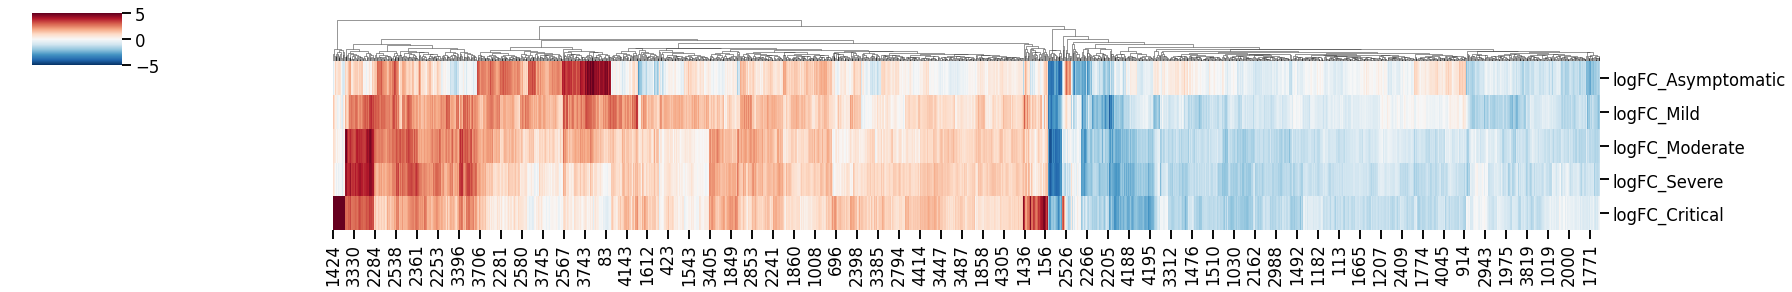

In [159]:
logFC_df = nhood_adata.obs[ [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
logFC_df = logFC_df.dropna()
logFC_df['nhood_id'] = logFC_df.index.copy()
nhood_order = logFC_df.sort_values('logFC_Critical')['nhood_id'].values

FDR_df = nhood_adata.obs[ [f'SpatialFDR_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
FDR_df = FDR_df.dropna()
FDR_df['nhood_id'] = FDR_df.index.copy()

## scale logFC for each test
lfc_df = logFC_df[[f'logFC_{sev}' for sev in order_severity[1:]]]
scaled_lfc_df = lfc_df/lfc_df.std(0)
logFC_df.loc[:,[f'logFC_{sev}' for sev in order_severity[1:]]] = scaled_lfc_df

## Select nhoods with at least one signif DA
signif_nhoods = (FDR_df[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0

## Get clustered order
a = sns.clustermap(logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]]].T, cmap='RdBu_r', figsize=(25,4), 
               vmax=5, vmin=-5, 
               row_cluster=False
              )
order_index = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]]].index[a.dendrogram_col.reordered_ind]

lfc_df = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_id']]

lfc_df = lfc_df.loc[order_index]

## Make cell type identity heatmap (1/0)
dummy_anno_df = logFC_df[['nhood_annotation', 'nhood_id']].loc[order_index]
dummy_anno_df['anno_group'] = [anno_group_rev[x] for x in dummy_anno_df['nhood_annotation']]
anno_group_order = list(anno_group_order)

lfc_df = pd.merge(lfc_df, dummy_anno_df)
lfc_df

In [160]:
plot_lfc_heatmap_str = '''
    plot_func <- function(args){
        lfc_df <- args[[1]]
        anno_group_order <- args[[2]]
        order_severity <- args[[3]]
        anno_hm <- lfc_df[c('nhood_id', 'nhood_annotation', 'anno_group')] %>%
            mutate(index = factor(nhood_id, levels=nhood_id)) %>%
            mutate(anno_group = factor(anno_group, levels=unlist(anno_group_order))) %>%
            ggplot(aes(index, nhood_annotation)) +
            geom_tile() +
            facet_grid(anno_group~., scales='free', space='free') +
            theme_grey(base_size=21) +
            remove_x_axis() +
            theme(strip.text.y=element_text(angle=0))

        lfc_hm <- lfc_df %>%
            select( - c('nhood_annotation', 'anno_group') ) %>%
            mutate(index = factor(nhood_id, levels=nhood_id)) %>%
            pivot_longer(cols= - c(index, nhood_id), values_to='scaled_logFC', names_to='Severity') %>%
            mutate(Severity = str_remove(Severity, 'logFC_')) %>%
            mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
            ggplot(aes(index, Severity, fill=scaled_logFC)) +
            geom_tile() +
            scale_fill_gradient2(midpoint=0, high='red', low='blue') +
            theme_grey(base_size=30) +
            remove_x_axis() 

        (anno_hm / lfc_hm) +
        plot_layout(heights=c(2,1))
    }
    '''
# ggsave(paste0(figdir, 'clustered_lfc_heatmap_annotated.pdf'), width = 25, height=15)
plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df, anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated',
              pl_width=25, pl_height=15)

plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.nhood_annotation == 'B_naive'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.Bnaive',
              pl_width=12, pl_height=7)

plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'B cells'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.Bcells',
              pl_width=12, pl_height=7)

plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'monos'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.monos',
              pl_width=15, pl_height=7)


plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'CD8 T'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.CD8T',

              pl_width=15, pl_height=7)

In [165]:
plot_lfc_heatmap_str = '''
    plot_func <- function(args){
        lfc_df <- args[[1]]
        anno_group_order <- args[[2]]
        order_severity <- args[[3]]
        anno_hm <- lfc_df[c('nhood_id', 'nhood_annotation', 'anno_group')] %>%
            mutate(index = factor(nhood_id, levels=nhood_id)) %>%
            mutate(anno_group = factor(anno_group, levels=unlist(anno_group_order))) %>%
            ggplot(aes(index, anno_group)) +
            geom_tile() +
            theme_grey(base_size=30) +
            ylab("Broad annotation") +
            remove_x_axis() +
            theme(strip.text.y=element_text(angle=0))

        lfc_hm <- lfc_df %>%
            select( - c('nhood_annotation', 'anno_group') ) %>%
            mutate(index = factor(nhood_id, levels=nhood_id)) %>%
            pivot_longer(cols= - c(index, nhood_id), values_to='scaled_logFC', names_to='Severity') %>%
            mutate(Severity = str_remove(Severity, 'logFC_')) %>%
            mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
            ggplot(aes(index, Severity, fill=scaled_logFC)) +
            geom_tile() +
            scale_fill_gradient2(midpoint=0, high='red', low='blue') +
            theme_grey(base_size=30) +
            remove_x_axis() 

        (anno_hm / lfc_hm) +
        plot_layout(heights=c(1.5,1))
    }
    '''
# ggsave(paste0(figdir, 'clustered_lfc_heatmap_annotated.pdf'), width = 25, height=15)
lfc_df = lfc_df[lfc_df.nhood_annotation != 'B_malignant']
plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df, anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_broad',
              pl_width=25, pl_height=15)

In [523]:
plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'NK'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.NK',
              pl_width=15, pl_height=7)

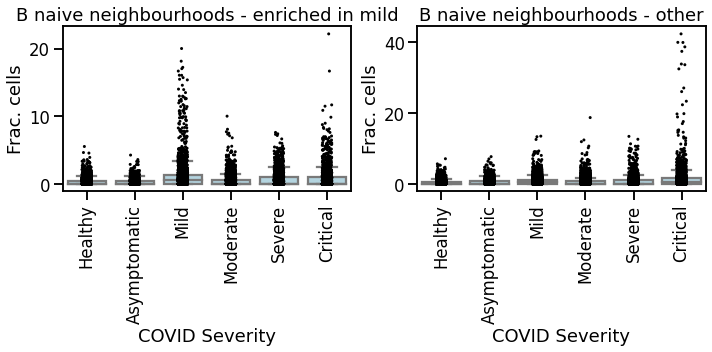

In [25]:
def plot_nhood_counts_by_severity(nhood_adata, n_ixs, normalize=False):
    tot_cells = np.array(nhood_adata[n_ixs].X.sum(1)).ravel()
    pl_df = pd.DataFrame(nhood_adata[n_ixs].X.A, columns = nhood_adata.var_names)
    if normalize:
        pl_df = (pl_df.T/tot_cells).T * 100
    pl_df = pl_df.melt(var_name='sample_id', value_name='n_cells')
    pl_df = pd.merge(pl_df, nhood_adata.var)
    pl_df = pl_df[pl_df['severity_cont'] >= 0]
    pl_df['log_n_cells'] = np.log1p(pl_df['n_cells'])
    pl_df['severity_cont'] = [order_severity[i] for i in pl_df['severity_cont']]
    pl_df['severity_cont'] = pl_df['severity_cont'].astype('category').cat.reorder_categories(order_severity)
    sns.boxplot(data=pl_df, x='severity_cont', y='n_cells', color='lightblue', showfliers = False);
    sns.stripplot(data=pl_df, x='severity_cont', y='n_cells', color='black', s=3);
    plt.xticks(rotation = 90); 
    plt.xlabel("COVID Severity"); 
    if normalize:
        plt.ylabel('Frac. cells');
    else:
        plt.ylabel('# cells');

lfc_df_bnaive = lfc_df[lfc_df.nhood_annotation == 'B_naive'].copy()
nhood_ixs = lfc_df[lfc_df.nhood_annotation == 'B_naive']['nhood_id'][0:100]

## Filter by significance
nhood_ixs = nhood_ixs.values[nhood_adata.obs.loc[nhood_ixs]['SpatialFDR_Mild'] < 0.1]

with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,2,1);
    plot_nhood_counts_by_severity(nhood_adata, nhood_ixs, normalize=True);
    plt.title("B naive neighbourhoods - enriched in mild");
    plt.subplot(1,2,2);
    plot_nhood_counts_by_severity(nhood_adata, lfc_df_bnaive['nhood_id'][~lfc_df_bnaive['nhood_id'].isin(nhood_ixs)], normalize=True);
    plt.title("B naive neighbourhoods - other")
    plt.tight_layout()


Plot illustrative example

In [108]:
all_enr = (nhood_adata.obs[[f'logFC_{s}' for s in order_severity[1:]]] > 0).sum(1) == len(order_severity[1:])
all_signif = (nhood_adata.obs[[f'SpatialFDR_{s}' for s in order_severity[1:]]] < 0.1).sum(1) > 3

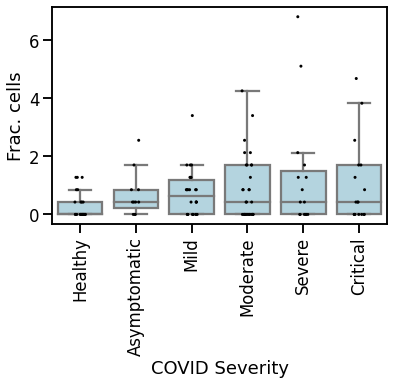

In [109]:
nhood_ixs = nhood_adata.obs_names[all_enr & all_signif]
plot_nhood_counts_by_severity(nhood_adata, nhood_ixs[17], normalize=True);

In [110]:
ix = nhood_ixs[17]
fdr = nhood_adata.obs[[f'SpatialFDR_{s}' for s in order_severity[1:]]].loc[ix].T
fdr.index = [x.split('SpatialFDR_')[1] for x in fdr.index]
lfc = nhood_adata.obs[[f'logFC_{s}' for s in order_severity[1:]]].loc[ix].T
lfc.index = [x.split('logFC_')[1] for x in lfc.index]
df = pd.concat([lfc, fdr], 1)
df.columns = ['logFC', 'SpatialFDR']
df

logFC  SpatialFDR
Asymptomatic  0.584417    0.874618
Mild          0.699006    0.061867
Moderate      0.534019    0.021091
Severe        0.493800    0.008706
Critical      0.345076    0.023954

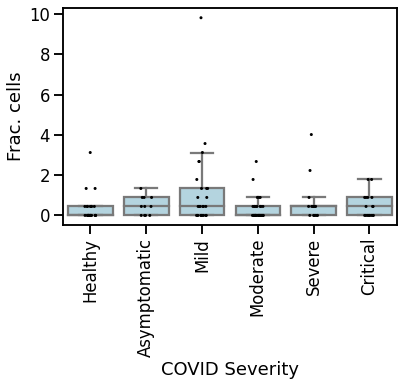

In [92]:
signif_mild = (nhood_adata.obs['logFC_Mild'] > 0) & (nhood_adata.obs['SpatialFDR_Mild'] < 0.1)
non_signif = (nhood_adata.obs[[f'SpatialFDR_{s}' for s in order_severity[3:]]] > 0.1).sum(1) == len(order_severity[3:])
non_enr = (nhood_adata.obs[[f'logFC_{s}' for s in order_severity[3:]]] < 0.1).sum(1) == len(order_severity[3:])

nhood_ixs = nhood_adata.obs_names[signif_mild & non_signif & non_enr]
plot_nhood_counts_by_severity(nhood_adata, nhood_ixs[6], normalize=True);

In [107]:
ix = nhood_ixs[6]
fdr = nhood_adata.obs[[f'SpatialFDR_{s}' for s in order_severity[1:]]].loc[ix].T
fdr.index = [x.split('SpatialFDR_')[1] for x in fdr.index]
lfc = nhood_adata.obs[[f'logFC_{s}' for s in order_severity[1:]]].loc[ix].T
lfc.index = [x.split('logFC_')[1] for x in lfc.index]
df = pd.concat([lfc, fdr], 1)
df.columns = ['logFC', 'SpatialFDR']
df

logFC  SpatialFDR
Asymptomatic  0.995682    0.720603
Mild          0.908150    0.008561
Moderate      0.035894    0.937847
Severe        0.033712    0.927971
Critical      0.008978    0.977725

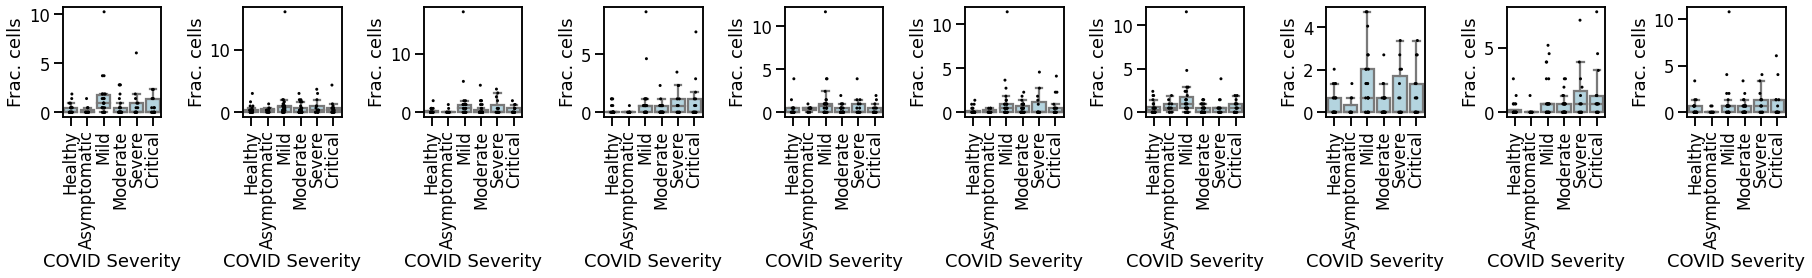

In [23]:
## Sanity check it's not just one donor
n = 10
with rc_context({'figure.figsize':[25,4]}):
    for ix,i in enumerate(np.random.choice(nhood_ixs, n)):
        plt.subplot(1,n,int(ix)+1);
        plot_nhood_counts_by_severity(nhood_adata, i, normalize=True);
    plt.tight_layout()

### Transitional state analysis 

... storing 'nhood_groups' as categorical


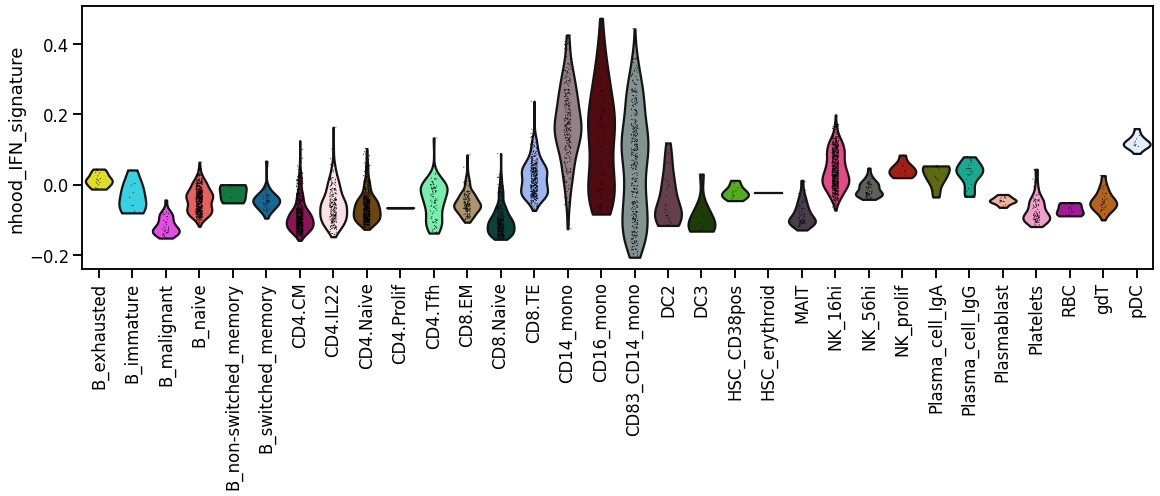

In [37]:
## Define transitional states for each cell type
with rc_context({'figure.figsize':[15,5]}):
    sc.pl.violin(nhood_adata, ['nhood_IFN_signature'], groupby='nhood_annotation', rotation=90)

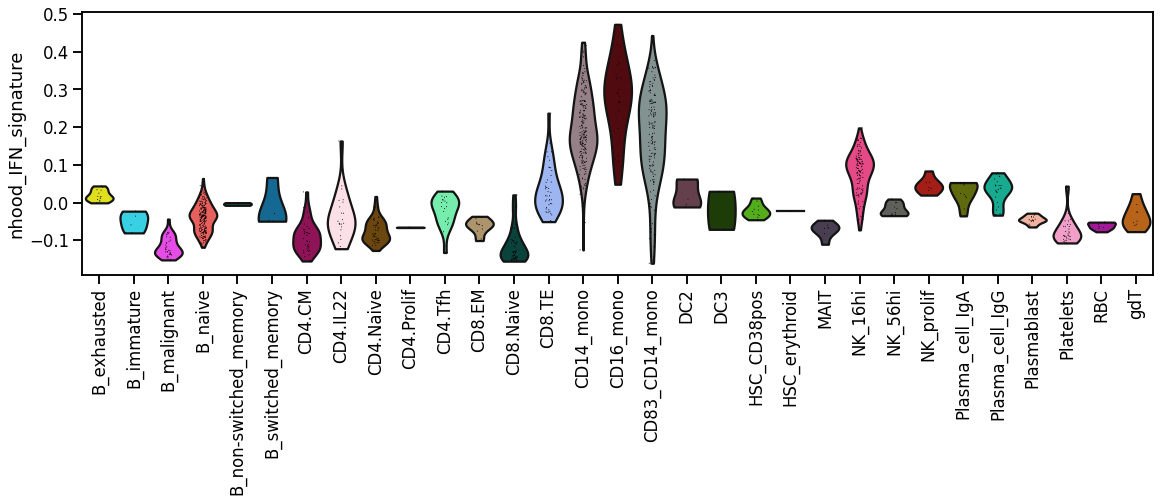

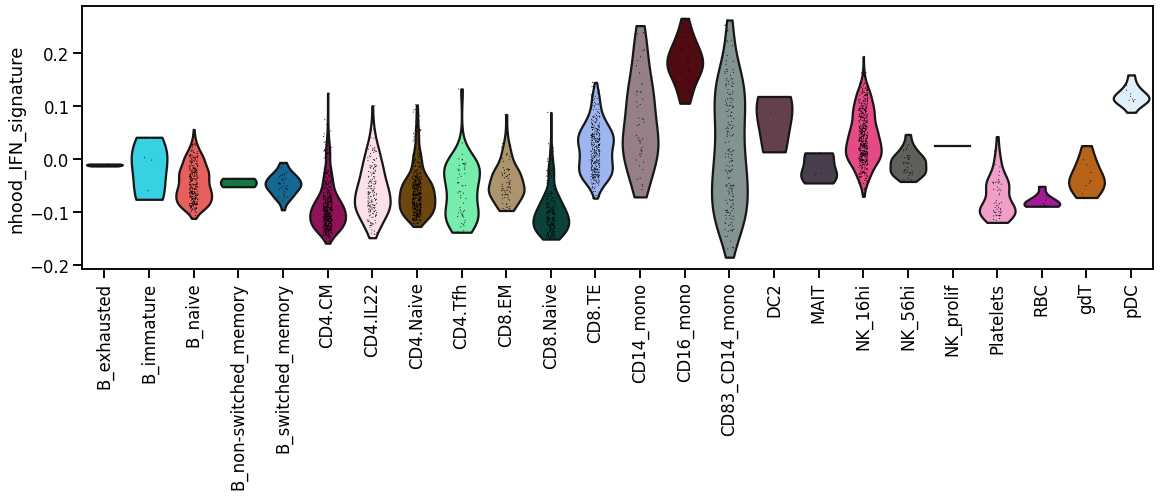

In [38]:
## Take nhoods enriched in COVID
signif_nhood = (nhood_adata.obs[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0
enr_nhood = (nhood_adata.obs[[f'logFC_{sev}' for sev in order_severity[1:]]] > 0).sum(1) > 0
with rc_context({'figure.figsize':[15,5]}):
    sc.pl.violin(nhood_adata[signif_nhood & enr_nhood], ['nhood_IFN_signature'], groupby='nhood_annotation', rotation=90)
    sc.pl.violin(nhood_adata[~signif_nhood], ['nhood_IFN_signature'], groupby='nhood_annotation', rotation=90);

In [115]:
fdr_cols = [f'SpatialFDR_{sev}' for sev in order_severity[1:]]
lfc_cols = [f'logFC_{sev}' for sev in order_severity[1:]]
pl_df = nhood_adata.obs[lfc_cols + fdr_cols + ['nhood_annotation', 'nhood_IFN_signature']]
lfc_df = pd.DataFrame()
for s in order_severity[1:]:
    lfc_sev_df = nhood_adata.obs[[f'logFC_{s}', f'SpatialFDR_{s}', 'nhood_annotation', 'nhood_IFN_signature']]
    lfc_sev_df.columns = [f'logFC', 'SpatialFDR', 'nhood_annotation', 'nhood_IFN_signature']
    lfc_sev_df['Severity'] = s
    lfc_df = pd.concat([lfc_df, lfc_sev_df], 0)
    
lfc_df['anno_group'] = [anno_group_rev[x] for x in lfc_df['nhood_annotation']]
lfc_df = lfc_df[lfc_df['nhood_annotation'] != 'B_malignant']

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


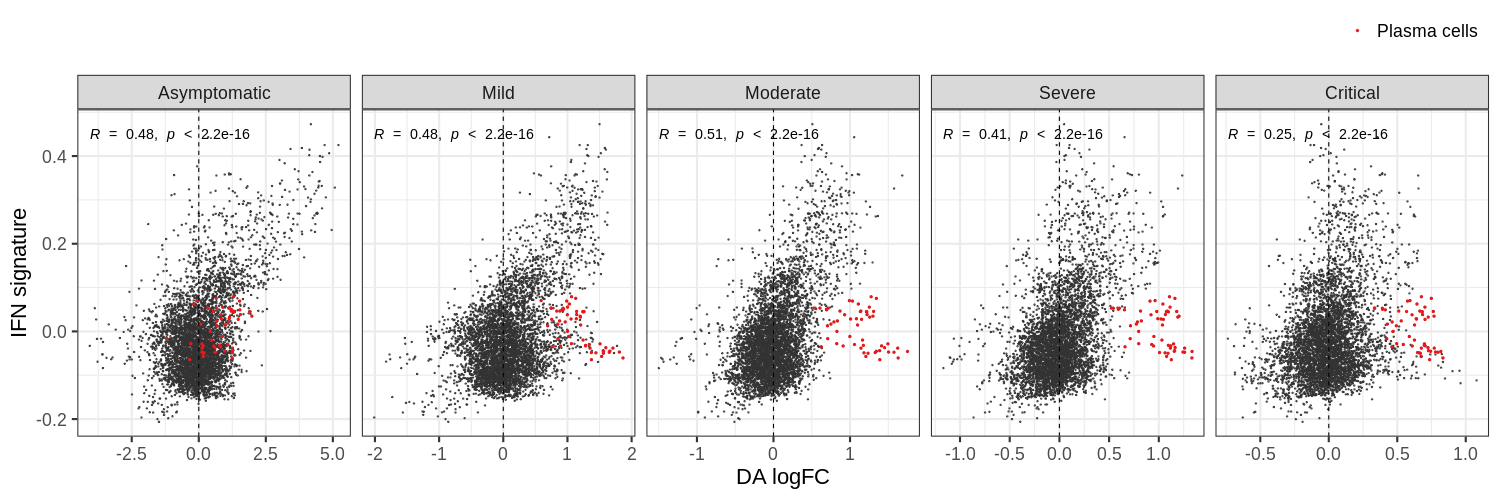

In [126]:
%%R -i lfc_df -i fdr_cols -i lfc_cols -w 1500 -h 500 -i order_severity -i figdir
lfc_df %>%
    mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
    ggplot(aes(logFC, nhood_IFN_signature)) +
    geom_point(size=0.5, alpha=0.8, color='grey20') +
    geom_point(data = . %>% filter(anno_group=="plasma"), aes(color='Plasma cells'), size=0.9, alpha=1) +
    # geom_point(data = . %>% filter(anno_group=="CD8 T"), aes(color='CD8+T'), size=0.9, alpha=1) +
    # geom_point(data = . %>% filter(anno_group=="B cells"), aes(color='B cells'), size=0.9, alpha=1) +
    facet_grid(.~Severity, scales='free_x') +
    scale_color_brewer(palette='Set1', name='') +
    theme_bw(base_size=22) +
    geom_vline(xintercept=0, linetype=2) +
    ylab("IFN signature") + xlab("DA logFC") +
    ggpubr::stat_cor(size=5) +
    theme(legend.position='top', legend.justification='right') +
    ggsave(paste0(figdir, 'IFNvsLogFC_severity.png'), width=15, height=6) +
    ggsave(paste0(figdir, 'IFNvsLogFC_severity.pdf'), width=15, height=6)


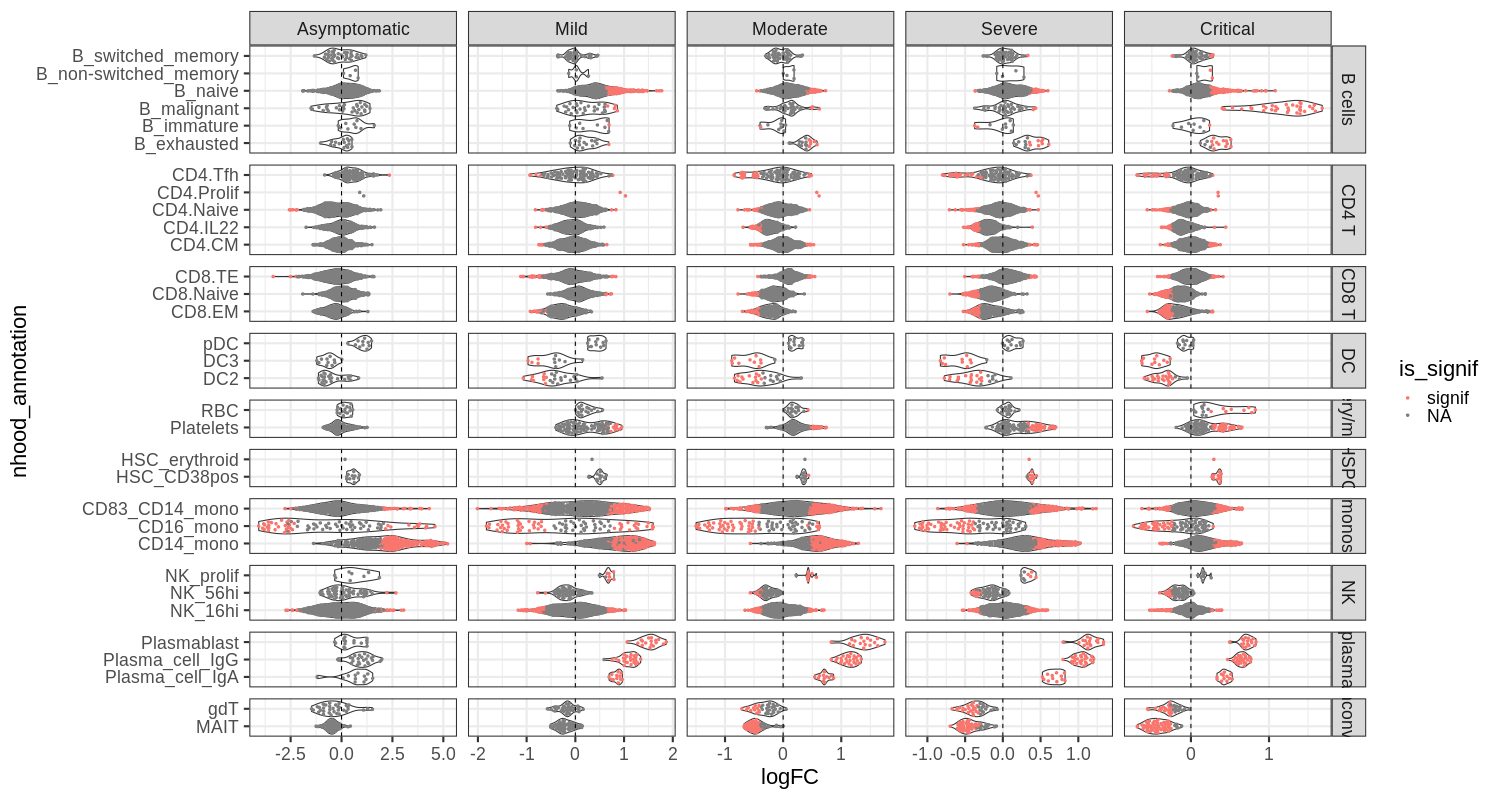

In [112]:
%%R -i lfc_df -i fdr_cols -i lfc_cols -w 1500 -h 800 -i order_severity
lfc_df %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(anno_group) %>%
mutate(scaled_IFN_signature = scale(nhood_IFN_signature)) %>%
arrange(scaled_IFN_signature) %>%
ungroup() %>%
mutate(is_signif = ifelse(SpatialFDR < 0.1, 'signif', NA)) %>%
ggplot(aes(nhood_annotation, y=logFC)) +
geom_violin(scale='width') +
ggbeeswarm::geom_quasirandom(aes(color=is_signif), size=1) +
coord_flip() +
facet_grid(anno_group~Severity, scales='free', space='free_y' ) +
theme_bw(base_size=22) +
# scale_color_viridis_c() +
geom_hline(yintercept=0, linetype=2)

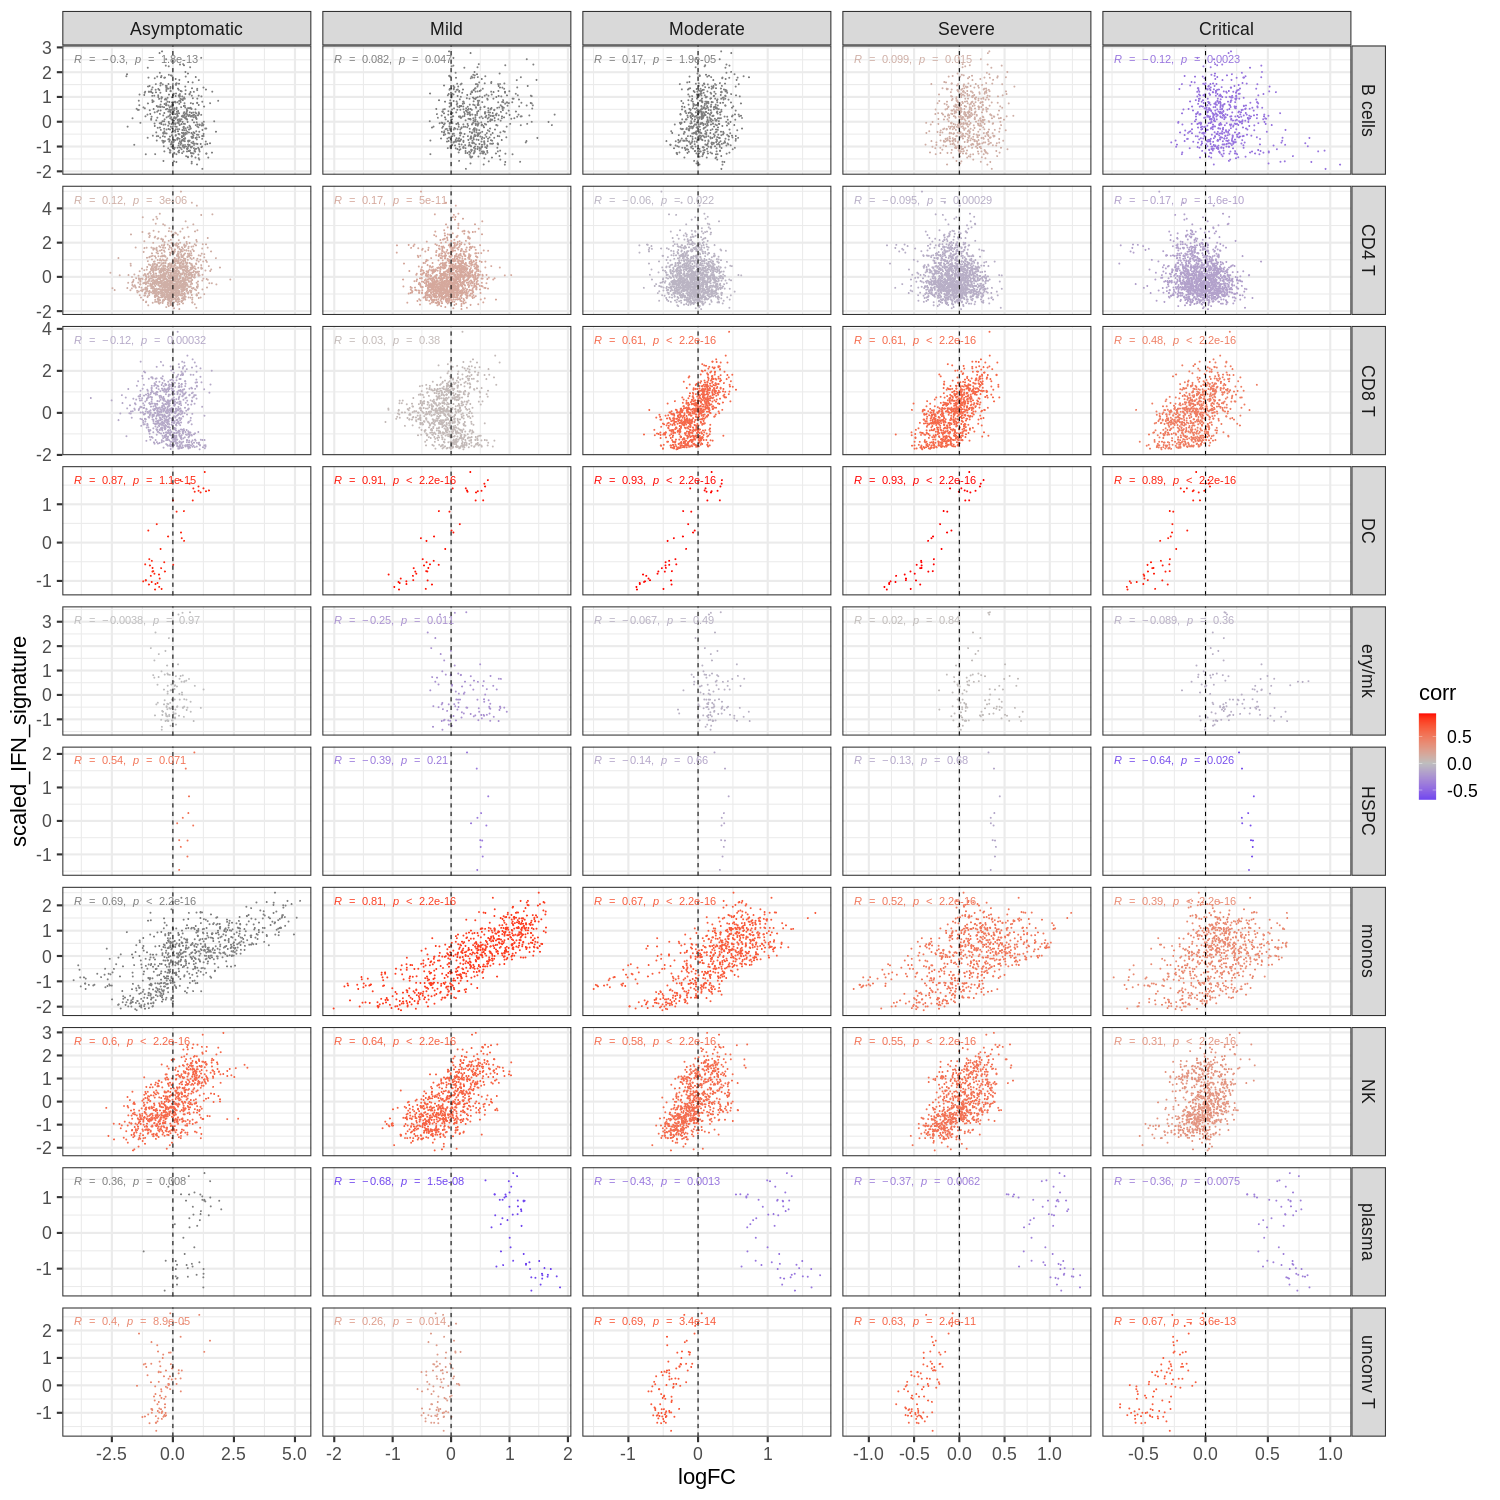

In [113]:
%%R -w 1500 -h 1500 -i order_severity
lfc_df %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(anno_group) %>%
mutate(scaled_IFN_signature = scale(nhood_IFN_signature)) %>%
arrange(scaled_IFN_signature) %>%
ungroup() %>%
group_by(anno_group, Severity) %>%
mutate(corr = cor(scaled_IFN_signature, logFC)) %>%
ungroup() %>%
filter(nhood_annotation != 'B_malignant') %>%
ggplot(aes(y=scaled_IFN_signature, x=logFC,color=corr)) +
geom_point(size=0.3) +
facet_grid(anno_group~Severity, scales='free') +
theme_bw(base_size=22) +
scale_color_gradient2(mid='grey', high='red', low='blue') +
geom_vline(xintercept=0, linetype=2) +
ggpubr::stat_cor()

`summarise()` has grouped output by 'anno_group'. You can override using the `.groups` argument.


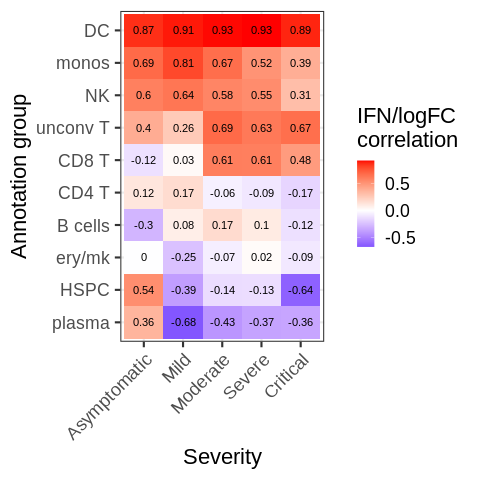

In [114]:
%%R
lfc_df %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
filter(nhood_annotation != 'B_malignant') %>%
group_by(anno_group) %>%
mutate(scaled_IFN_signature = scale(nhood_IFN_signature)) %>%
arrange(scaled_IFN_signature) %>%
ungroup() %>%
group_by(anno_group, Severity) %>%
summarise(corr = cor(scaled_IFN_signature, logFC, use="complete.obs")) %>%
ungroup() %>%
group_by(anno_group) %>%
mutate(mean_corr = mean(corr)) %>%
ungroup() %>%
arrange(mean_corr) %>%
mutate(anno_group = factor(anno_group, levels=unique(anno_group))) %>%
ggplot(aes(y=anno_group, x=Severity, fill=corr)) +
geom_tile() +
geom_text( aes(label=round(corr, 2))) +
theme_bw(base_size=22) +
ylab('Annotation group') +
scale_fill_gradient2(mid='white', high='red', low='blue', name='IFN/logFC\ncorrelation')  +
theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1))


- For high IFN cell types (e.g. monos, NK cells, DCs), the correlation falls in advanced stages of disease. Possibly this is due to the ifn signal going down, so low ifn cell states become more abundant
- Opposite in CD8 and unconventional T cells: low IFN CD8+T cells enriched in asymptomatic and mild cases

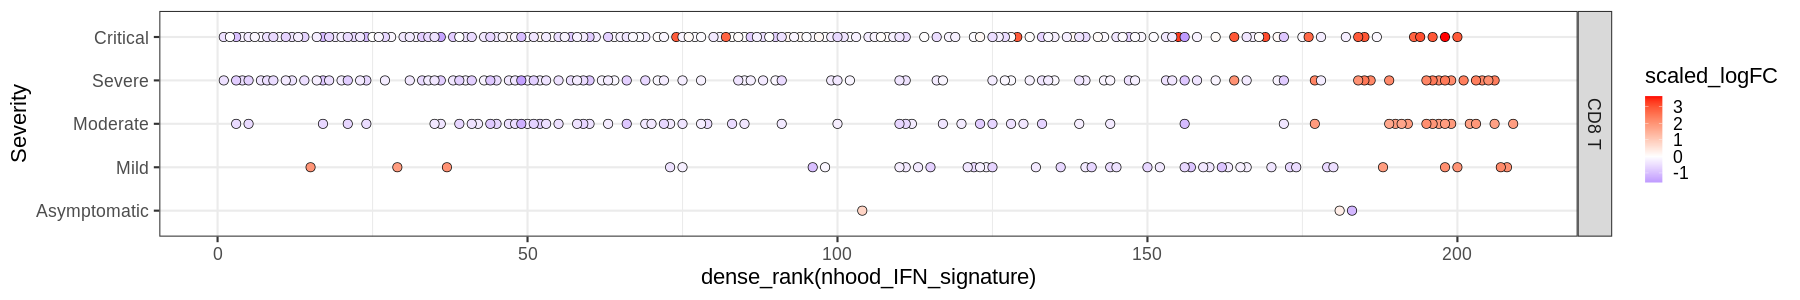

In [50]:
%%R -w 1800 -h 300 -i lfc_df
lfc_df %>%
filter(anno_group == 'CD8 T') %>%
filter(SpatialFDR < 0.1) %>%
# mutate(Severity = str_remove(Severity, 'logFC_')) %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(Severity) %>%
mutate(scaled_logFC = scale(logFC)) %>%
ggplot(aes(x=dense_rank(nhood_IFN_signature), y=Severity, fill=scaled_logFC)) +
# geom_tile() +
geom_point(size=4, pch=21) +
facet_grid(anno_group~., scales='free', space='free') +
theme_bw(base_size=22) +
scale_color_gradient2(mid='white', high='red', low='blue') +
scale_fill_gradient2(mid='white', high='red', low='blue') 

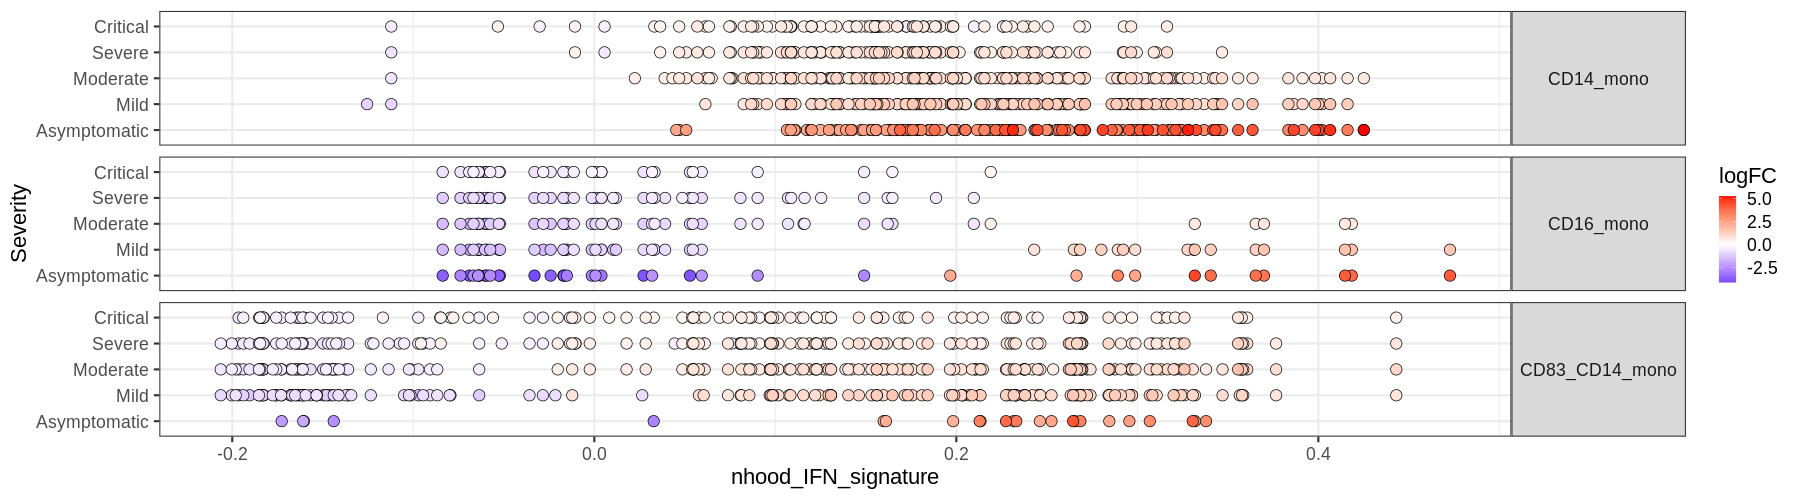

In [926]:
%%R -w 1800 -h 500 -i lfc_df
lfc_df %>%
filter(anno_group == 'monos') %>%
filter((SpatialFDR < 0.1 )) %>%
# mutate(Severity = str_remove(Severity, 'logFC_')) %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(Severity) %>%
mutate(scaled_logFC = scale(logFC)) %>%
arrange(scaled_logFC) %>%
ggplot(aes(x=nhood_IFN_signature, y=Severity, fill=logFC)) +
# geom_tile() +
geom_point(size=5, pch=21) +
facet_grid(nhood_annotation~., scales='free', space='free') +
theme_bw(base_size=22) +
scale_color_gradient2(mid='white', high='red', low='blue', midpoint=0) +
scale_fill_gradient2(mid='white', high='red', low='blue', midpoint=0) +
theme(strip.text.y=element_text(angle=0))

In [927]:
lfc_df.groupby('Severity')

logFC  SpatialFDR nhood_annotation  nhood_IFN_signature  \
0     0.157223    0.973210          NK_16hi            -0.002200   
1    -0.617565    0.826834        CD8.Naive            -0.065815   
2    -0.147530    0.977665          B_naive            -0.075459   
3    -0.341551    0.942384           CD4.CM            -0.067536   
4    -0.511469    0.876407           CD4.CM            -0.140777   
...        ...         ...              ...                  ...   
4784  0.107893    0.558459           CD8.TE            -0.005379   
4785 -0.141068    0.350666           CD4.CM            -0.071640   
4786 -0.270063    0.065422              gdT            -0.049021   
4787 -0.074788    0.692801          NK_16hi             0.034771   
4788  0.296020    0.057066        Platelets            -0.083112   

          Severity anno_group  
0     Asymptomatic         NK  
1     Asymptomatic      CD8 T  
2     Asymptomatic    B cells  
3     Asymptomatic      CD4 T  
4     Asymptomatic      CD4 T  
...            ...        ...  
4784      Critical      CD8 T  
4785      Critical      CD4 T  
4786      Critical   unconv T  
4787      Critical         NK  
4788      Critical     ery/mk  

[23945 rows x 6 columns]

In [217]:
nhood_adata.layers['counts'] = nhood_adata.X.copy()
sc.pp.normalize_per_cell(nhood_adata, counts_per_cell_after=100)

In [223]:
sc.pp.log1p(nhood_adata)

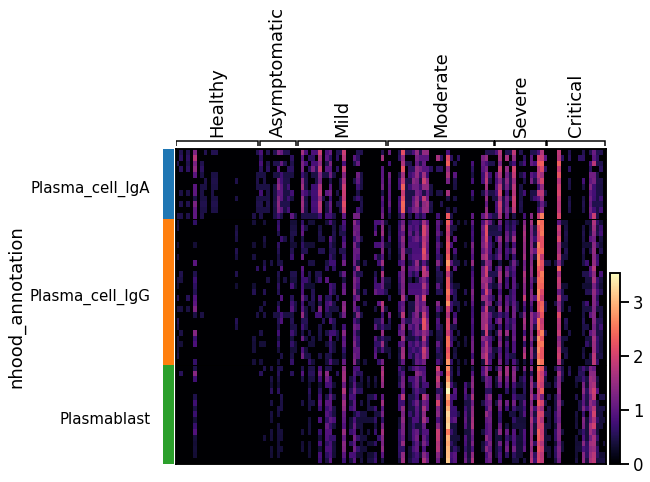

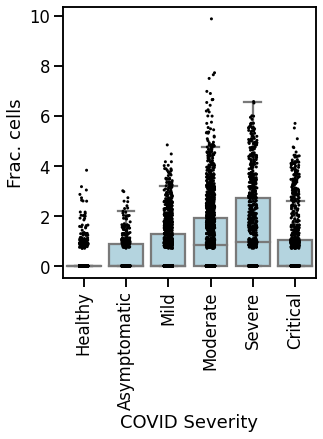

In [227]:
sev_samples_dict = {}
for s in range(0,6):
    sev_samples_dict[order_severity[s]] = nhood_adata.var_names[nhood_adata.var.severity_cont == s].values

sns.set_context('talk')
nhood_ixs = nhood_adata.obs_names[nhood_adata.obs['nhood_annotation'].isin(anno_groups['plasma'])]
sc.pl.heatmap(nhood_adata[nhood_ixs], sev_samples_dict, groupby='nhood_annotation', cmap='magma')


with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,2,1);
    plot_nhood_counts_by_severity(nhood_adata, nhood_ixs, normalize=True);

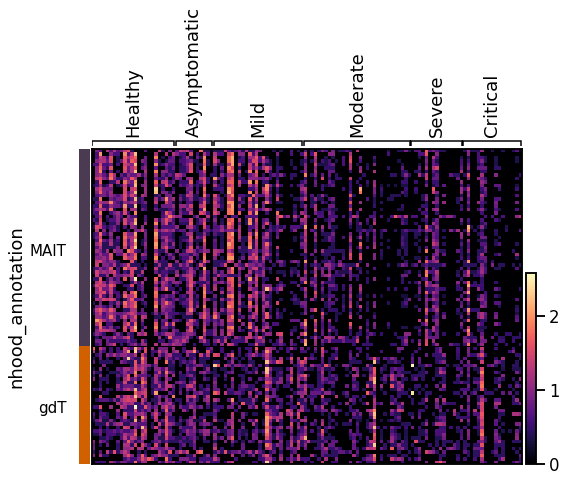

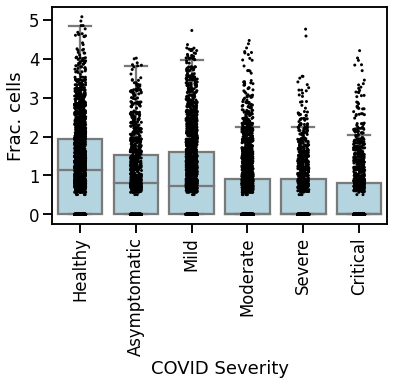

In [238]:
nhood_ixs = nhood_adata.obs_names[nhood_adata.obs['nhood_annotation'].isin(anno_groups['unconv T'])]
sc.pl.heatmap(nhood_adata[nhood_ixs], sev_samples_dict, groupby='nhood_annotation', cmap='magma')
plot_nhood_counts_by_severity(nhood_adata, nhood_ixs, normalize=True);

In [242]:
adata.obs["MKI67_expression"] = (
    adata[:, "MKI67"].X.toarray().ravel()
)
milopy.utils.annotate_nhoods_continuous(adata, "MKI67_expression")

<AxesSubplot:xlabel='nhood_MKI67_expression', ylabel='logFC_Asymptomatic'>

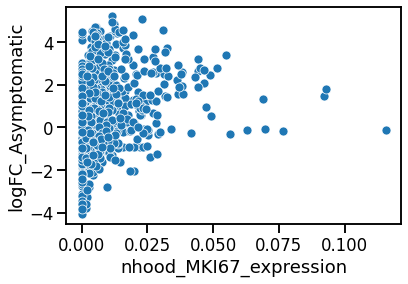

In [251]:
nhood_adata = adata.uns['nhood_adata'].copy()
sns.scatterplot(data=nhood_adata.obs[nhood_adata.obs.nhood_annotation.isin(anno_groups['monos'])], x='nhood_MKI67_expression', y='logFC_Asymptomatic')

## Plot neighbourhood groups of interest

In [129]:
nhood_adata.obs['nhood_groups'] = [anno_group_rev[x] for x in nhood_adata.obs['nhood_annotation']]

In [148]:
fdr_cols = [f'SpatialFDR_{sev}' for sev in order_severity[1:]]
lfc_cols = [f'logFC_{sev}' for sev in order_severity[1:]]
pl_df = nhood_adata.obs[lfc_cols + fdr_cols + ['nhood_annotation', 'nhood_IFN_signature', 'nhood_groups']]
lfc_df = pd.DataFrame()
for s in order_severity[1:]:
    lfc_sev_df = nhood_adata.obs[[f'logFC_{s}', f'SpatialFDR_{s}', 'nhood_annotation', 'nhood_IFN_signature', 'nhood_groups']]
    lfc_sev_df['nhood_id'] = nhood_adata.obs_names.values
    lfc_sev_df.columns = [f'logFC', 'SpatialFDR', 'nhood_annotation', 'nhood_IFN_signature', 'nhood_groups', 'nhood_id']
    lfc_sev_df['Severity'] = s
    lfc_sev_df = lfc_sev_df[lfc_sev_df['nhood_annotation'] != 'B_malignant']
    lfc_sev_df['scaled_logFC'] = lfc_sev_df.logFC/lfc_sev_df.logFC.std(0)
    lfc_df = pd.concat([lfc_df, lfc_sev_df], 0)
    
lfc_df['anno_group'] = [anno_group_rev[x] for x in lfc_df['nhood_annotation']]
lfc_df['nhood_groups'] = lfc_df['nhood_groups'].astype('str')


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [149]:
lfc_df

logFC  SpatialFDR nhood_annotation  nhood_IFN_signature nhood_groups  \
0     0.157223    0.973210          NK_16hi            -0.002200           NK   
1    -0.617565    0.826834        CD8.Naive            -0.065815        CD8 T   
2    -0.147530    0.977665          B_naive            -0.075459      B cells   
3    -0.341551    0.942384           CD4.CM            -0.067536        CD4 T   
4    -0.511469    0.876407           CD4.CM            -0.140777        CD4 T   
...        ...         ...              ...                  ...          ...   
4784  0.107893    0.558459           CD8.TE            -0.005379        CD8 T   
4785 -0.141068    0.350666           CD4.CM            -0.071640        CD4 T   
4786 -0.270063    0.065422              gdT            -0.049021     unconv T   
4787 -0.074788    0.692801          NK_16hi             0.034771           NK   
4788  0.296020    0.057066        Platelets            -0.083112       ery/mk   

     nhood_id      Severity  scaled_logFC anno_group  
0           0  Asymptomatic      0.157169         NK  
1           1  Asymptomatic     -0.617354      CD8 T  
2           2  Asymptomatic     -0.147479    B cells  
3           3  Asymptomatic     -0.341435      CD4 T  
4           4  Asymptomatic     -0.511295      CD4 T  
...       ...           ...           ...        ...  
4784     4784      Critical      0.511227      CD8 T  
4785     4785      Critical     -0.668414      CD4 T  
4786     4786      Critical     -1.279630   unconv T  
4787     4787      Critical     -0.354365         NK  
4788     4788      Critical      1.402619     ery/mk  

[23780 rows x 9 columns]

In [154]:
logFC_df.std(axis=0)

logFC_Asymptomatic     1.000000
logFC_Mild             1.000000
logFC_Moderate         1.000000
logFC_Severe           1.000000
logFC_Critical         1.000000
nhood_IFN_signature    0.098951
dtype: float64

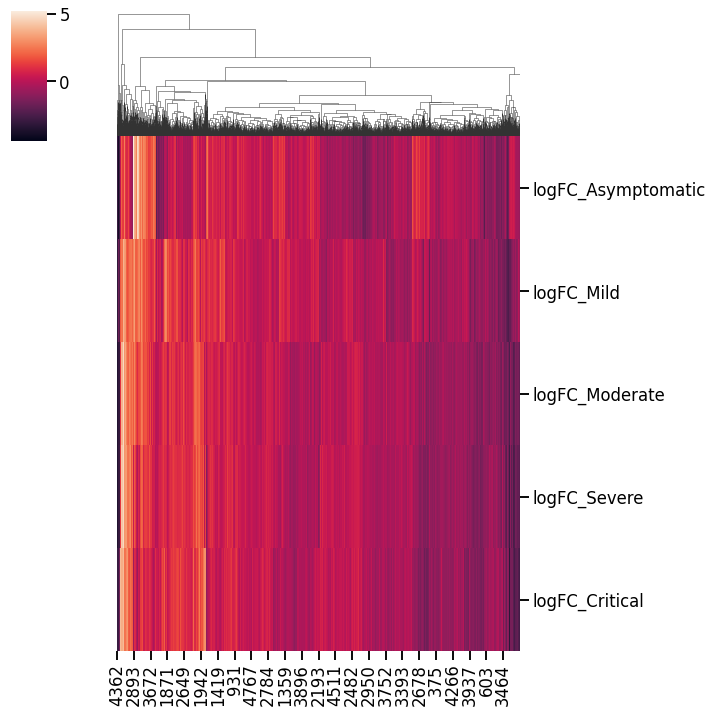

In [155]:
def order_nhoods_w_clustering(nhood_adata, obs_names):
    lfc_cols = [f'logFC_{sev}' for sev in order_severity[1:]]
    logFC_df = nhood_adata[obs_names].obs[lfc_cols].copy()
    logFC_df = logFC_df.dropna()
    logFC_df = logFC_df / logFC_df.std(axis=0)
    a = sns.clustermap(logFC_df.T, row_cluster=False)
    return(obs_names[a.dendrogram_col.reordered_ind])

order_index = order_nhoods_w_clustering(nhood_adata, lfc_df['nhood_id'].unique())

In [156]:
%%R -i lfc_df -i order_index
head(lfc_df)

       logFC SpatialFDR nhood_annotation nhood_IFN_signature nhood_groups
1  0.1572227  0.9732099          NK_16hi         -0.00220008           NK
2 -0.6175647  0.8268338        CD8.Naive         -0.06581493        CD8 T
3 -0.1475295  0.9776651          B_naive         -0.07545920      B cells
4 -0.3415511  0.9423840           CD4.CM         -0.06753626        CD4 T
5 -0.5114688  0.8764072           CD4.CM         -0.14077664        CD4 T
6  0.6135660  0.8645594          CD4.Tfh         -0.02367600        CD4 T
  nhood_id     Severity scaled_logFC anno_group
1        0 Asymptomatic    0.1571691         NK
2        1 Asymptomatic   -0.6173544      CD8 T
3        2 Asymptomatic   -0.1474793    B cells
4        3 Asymptomatic   -0.3414348      CD4 T
5        4 Asymptomatic   -0.5112946      CD4 T
6        5 Asymptomatic    0.6133570      CD4 T


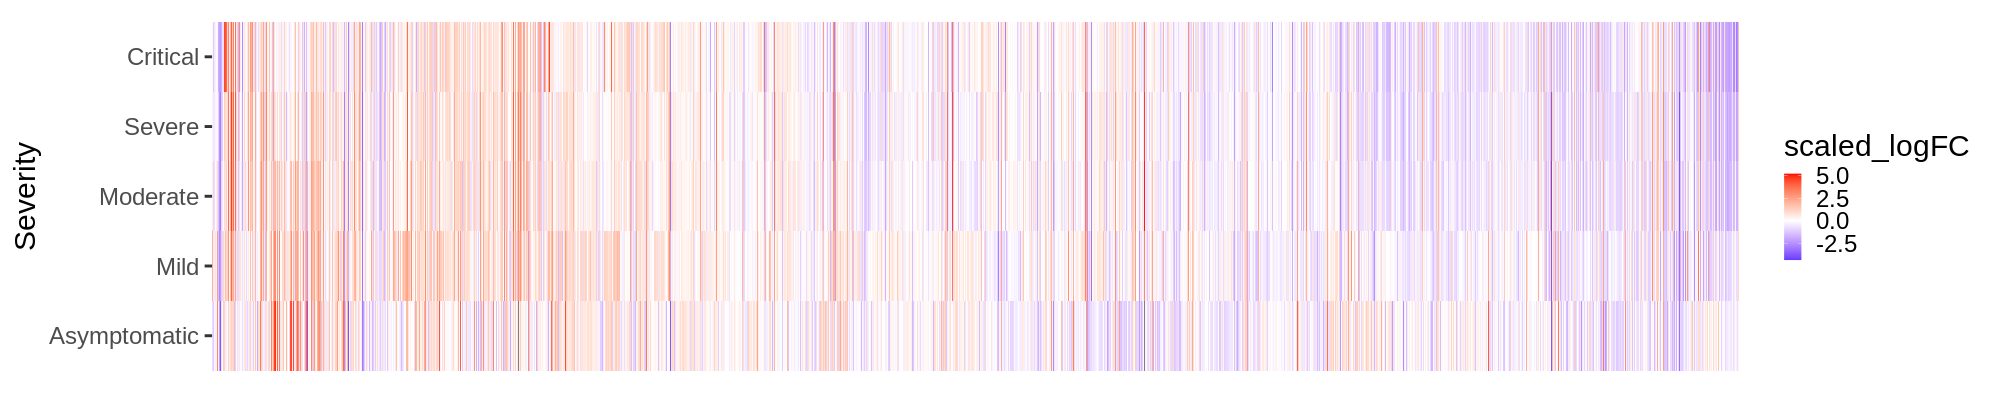

In [158]:
%%R -w 2000 -h 400
lfc_pl_df  <- lfc_df %>%
#     filter(anno_group == 'monos') %>%
# filter(nhood_annotation == 'B_naive') %>%
    filter(nhood_id %in% unlist(order_index)) %>%
    mutate(nhood_id = factor(nhood_id, levels=unlist(order_index))) %>%
    mutate(Severity = factor(Severity, levels=unlist(order_severity))) 
#     %>%
#     mutate(scaled_logFC = ifelse(SpatialFDR < 0.1, scaled_logFC, 0)) 
    
# pl1 <- 
lfc_pl_df %>%
    ggplot(aes(nhood_id, Severity)) +
    geom_tile(aes(fill=scaled_logFC)) +
    scale_fill_gradient2(midpoint=0, high='red', low='blue') +
    theme_grey(base_size=30) +
#     facet_grid(.~anno_group, scales='free_x', space='free') +
    remove_x_axis()

# pl2 <- lfc_pl_df %>%
#     ggplot(aes(nhood_id, 1, fill=nhood_groups)) + geom_tile() +
#     remove_x_axis() + remove_y_axis()
    
# pl1 / pl2
# pl1

'/usr/lib/R'

## DE analysis 

In [171]:
import diff2atlas

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args)
    de_res_df = pd.DataFrame(de_res_df)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    sdata.X = sdata.layers['counts'].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)

    
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'in_nhoods_{ctrl_group}', 
                           contrast = f'nhood_groupsin_nhoods_{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

### B naive nhood groups

In [260]:
logFC_df = nhood_adata.obs[ [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
logFC_df = logFC_df.dropna()
logFC_df['nhood_id'] = logFC_df.index.copy()
nhood_order = logFC_df.sort_values('logFC_Critical')['nhood_id'].values

FDR_df = nhood_adata.obs[ [f'SpatialFDR_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
FDR_df = FDR_df.dropna()
FDR_df['nhood_id'] = FDR_df.index.copy()

## scale logFC for each test
lfc_df = logFC_df[[f'logFC_{sev}' for sev in order_severity[1:]]]
scaled_lfc_df = lfc_df/lfc_df.std(0)
logFC_df.loc[:,[f'logFC_{sev}' for sev in order_severity[1:]]] = scaled_lfc_df

## Select nhoods with at least one signif DA
signif_nhoods = (FDR_df[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0
lfc_df = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_id']]

lfc_df = lfc_df.loc[order_index]

## Make cell type identity heatmap (1/0)
dummy_anno_df = logFC_df[['nhood_annotation', 'nhood_id']].loc[order_index]
dummy_anno_df['anno_group'] = [anno_group_rev[x] for x in dummy_anno_df['nhood_annotation']]
anno_group_order = list(anno_group_order)

lfc_df = pd.merge(lfc_df, dummy_anno_df)
lfc_df

logFC_Asymptomatic  logFC_Mild  logFC_Moderate  logFC_Severe  \
0              -0.643331    1.365259        0.908265      0.785217   
1               0.771672    1.257700        0.840087      0.711407   
2               0.142558    0.930505        0.703720      0.465286   
3               1.135137    0.333982        0.499920      0.027060   
4               0.576815    0.388620        0.049313     -0.373632   
...                  ...         ...             ...           ...   
1628           -1.700730   -1.535745       -1.412362     -1.326208   
1629           -1.485686   -1.767079       -1.491987     -1.405349   
1630           -1.543066   -1.853977       -1.295473     -1.702468   
1631           -1.699038   -2.071097       -1.375262     -1.318493   
1632           -1.379872   -1.740838       -1.183171     -1.102078   

      logFC_Critical nhood_id nhood_annotation anno_group  
0           6.096818     1424      B_malignant    B cells  
1           6.154769     1431      B_malignant    B cells  
2           6.129770     1452      B_malignant    B cells  
3           5.458437     1429      B_malignant    B cells  
4           5.335318     1456      B_malignant    B cells  
...              ...      ...              ...        ...  
1628       -0.695261     3909   CD83_CD14_mono      monos  
1629       -0.834786     4111   CD83_CD14_mono      monos  
1630       -1.049069     4285   CD83_CD14_mono      monos  
1631       -0.363197     3652          NK_16hi         NK  
1632       -0.107615     4379   CD83_CD14_mono      monos  

[1633 rows x 8 columns]

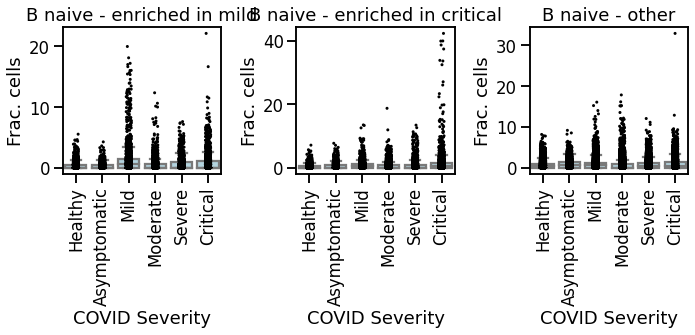

In [262]:
### Pick neighbourhoods of interest
lfc_df_bnaive = lfc_df[lfc_df.nhood_annotation == 'B_naive'].copy()
nhood_ixs = lfc_df[lfc_df.nhood_annotation == 'B_naive']['nhood_id'][0:100]

nhoods_mild = lfc_df_bnaive['nhood_id'][lfc_df_bnaive['nhood_id'].isin(nhood_ixs)].values
nhoods_crit = lfc_df_bnaive['nhood_id'][~lfc_df_bnaive['nhood_id'].isin(nhood_ixs)].values
nhoods_other = nhood_adata.obs_names[(nhood_adata.obs.nhood_annotation == 'B_naive') & (~nhood_adata.obs_names.isin(lfc_df.nhood_id))]

with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,3,1);
    plot_nhood_counts_by_severity(nhood_adata, nhoods_mild, normalize=True);
    plt.title("B naive - enriched in mild");
    plt.subplot(1,3,2);
    plot_nhood_counts_by_severity(nhood_adata, nhoods_crit, normalize=True);
    plt.title("B naive - enriched in critical")
    plt.subplot(1,3,3);
    plot_nhood_counts_by_severity(nhood_adata, nhoods_other, normalize=True);
    plt.title("B naive - other")
    plt.tight_layout()

nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[nhoods_mild, 'nhood_groups'] = 'mild_enr'
nhood_adata.obs.loc[nhoods_crit, 'nhood_groups'] = 'critical_enr'
nhood_adata.obs.loc[nhoods_other, 'nhood_groups'] = 'other'
adata.uns['nhood_adata'] = nhood_adata.copy()

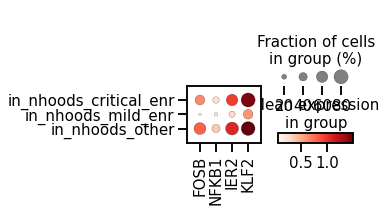

In [290]:
sc.pl.dotplot(adata[(adata.obs['author_cell_type'] == 'B_naive') & (adata.obs['severity_cont'] == 2)], 
              ['FOSB', "NFKB1", 'IER2', "KLF2"], groupby='nhood_groups')

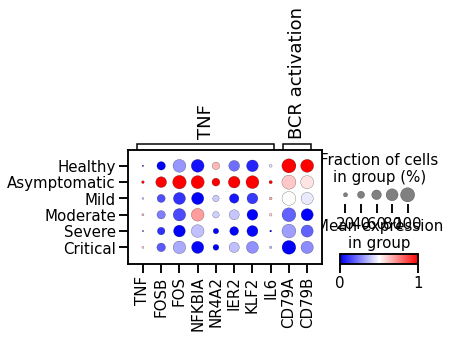

In [312]:
sdata = adata[(adata.obs['author_cell_type'] == 'B_naive') & (adata.obs['severity_cont'] >= 0) ]
sdata.obs['Status_on_day_collection_summary'] = sdata.obs['Status_on_day_collection_summary'].cat.reorder_categories(order_severity)
sc.pl.dotplot(sdata, 
              {'TNF':['TNF','FOSB','FOS', "NFKBIA", 'NR4A2','IER2', "KLF2", "IL6"],'BCR activation':['CD79A', "CD79B"]}, 
              groupby='Status_on_day_collection_summary', standard_scale='var', cmap='bwr')

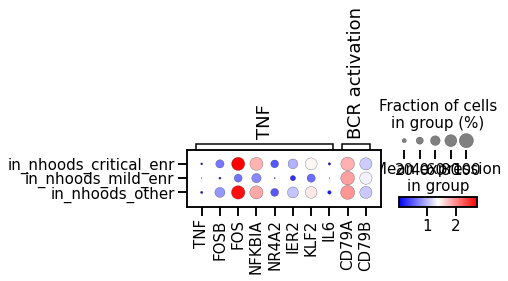

In [313]:
sc.pl.dotplot(sdata[sdata.obs['severity_cont'] == 2], 
              {'TNF':['TNF','FOSB','FOS', "NFKBIA", 'NR4A2','IER2', "KLF2", "IL6"],'BCR activation':['CD79A', "CD79B"]}, 
              groupby='nhood_groups',  cmap='bwr')

In [324]:
[x for x in sdata.var_names if x.startswith("IGH")]

['IGHMBP2']

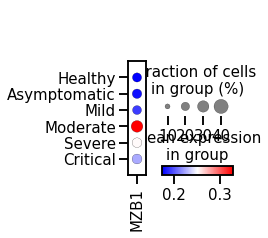

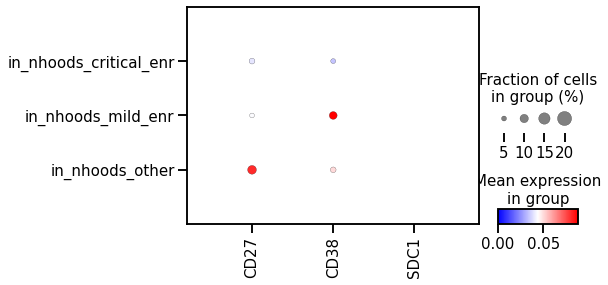

In [337]:
sc.pl.dotplot(sdata, 
              'MZB1', 
              groupby='Status_on_day_collection_summary',  cmap='bwr')
sc.pl.dotplot(sdata[sdata.obs['severity_cont'] == 2], 
              ['CD27', 'CD38', 'SDC1'], 
              groupby='nhood_groups',  cmap='bwr', figsize=[7,4], swap_axes=False);


In [58]:
## Run DE testing
DE_Bnaive_critical = find_nhood_group_markers(
    adata, 
    test_group='critical_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

DE_Bnaive_mild = find_nhood_group_markers(
    adata, 
    test_group='mild_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

In [60]:
## Save 
DE_Bnaive_critical['contrast'] = 'critical_enr-other'
DE_Bnaive_mild['contrast'] = 'mild_enr-other'
DE_Bnaive = pd.concat([DE_Bnaive_mild, DE_Bnaive_critical])
DE_Bnaive.to_csv(resdir + 'DEresults_BnaiveNhoods.csv')

In [68]:
DE_Bnaive

pval      adj_pval  f_statistic  df1         df2  \
gene_name                                                             
EEF1G      9.965075e-01  9.998798e-01     0.000019    1  361.116601   
RPS4Y1     6.599756e-01  8.455847e-01     0.193873    1  361.116601   
MTRNR2L8   5.265980e-01  7.672996e-01     0.401731    1  361.116601   
FOS        1.651514e-52  3.217701e-49   327.054442    1  361.116601   
HBB        6.247273e-02  2.560681e-01     3.492073    1  361.116601   
...                 ...           ...          ...  ...         ...   
SOX13      5.265625e-01  8.467202e-01     0.401800    1  361.116601   
RFPL1S     5.205077e-01  8.454445e-01     0.413696    1  361.116601   
TMIGD3     7.422053e-02  4.253127e-01     3.205681    1  361.116601   
DDR2       7.422053e-02  4.253127e-01     3.205681    1  361.116601   
CLVS1      7.422053e-02  4.253127e-01     3.205681    1  361.116601   

                 lfc gene_name            contrast  
gene_name                                           
EEF1G      -0.000358     EEF1G      mild_enr-other  
RPS4Y1      0.150871    RPS4Y1      mild_enr-other  
MTRNR2L8    0.356794  MTRNR2L8      mild_enr-other  
FOS        -2.634922       FOS      mild_enr-other  
HBB        -1.142329       HBB      mild_enr-other  
...              ...       ...                 ...  
SOX13     -21.811663     SOX13  critical_enr-other  
RFPL1S    -21.755911    RFPL1S  critical_enr-other  
TMIGD3     26.569961    TMIGD3  critical_enr-other  
DDR2       26.569961      DDR2  critical_enr-other  
CLVS1      26.569961     CLVS1  critical_enr-other  

[11690 rows x 8 columns]

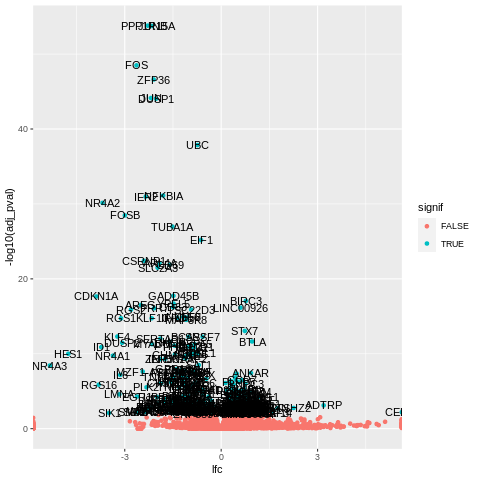

In [69]:
%%R -i DE_Bnaive
max_lfc = 15
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.5), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

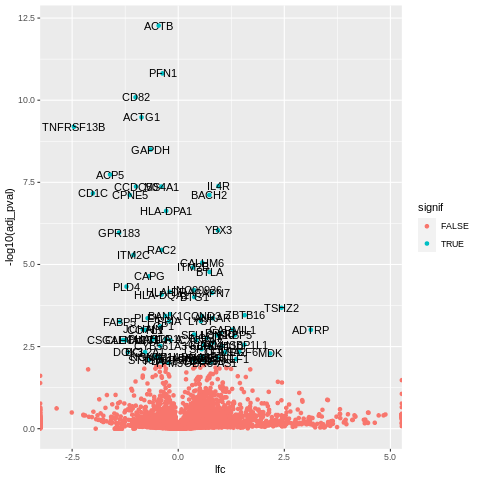

In [71]:
%%R -i DE_Bnaive
max_lfc = 15
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    filter(contrast == 'critical_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.2), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

In [148]:
%%R -w 800 -h 800
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_critical < 0.1) & (adj_pval_mild < 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

crit_specific_pl <- DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_critical < 0.1) & (adj_pval_mild > 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)
    
mild_specific_pl <- DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_critical > 0.1) & (adj_pval_mild <= 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

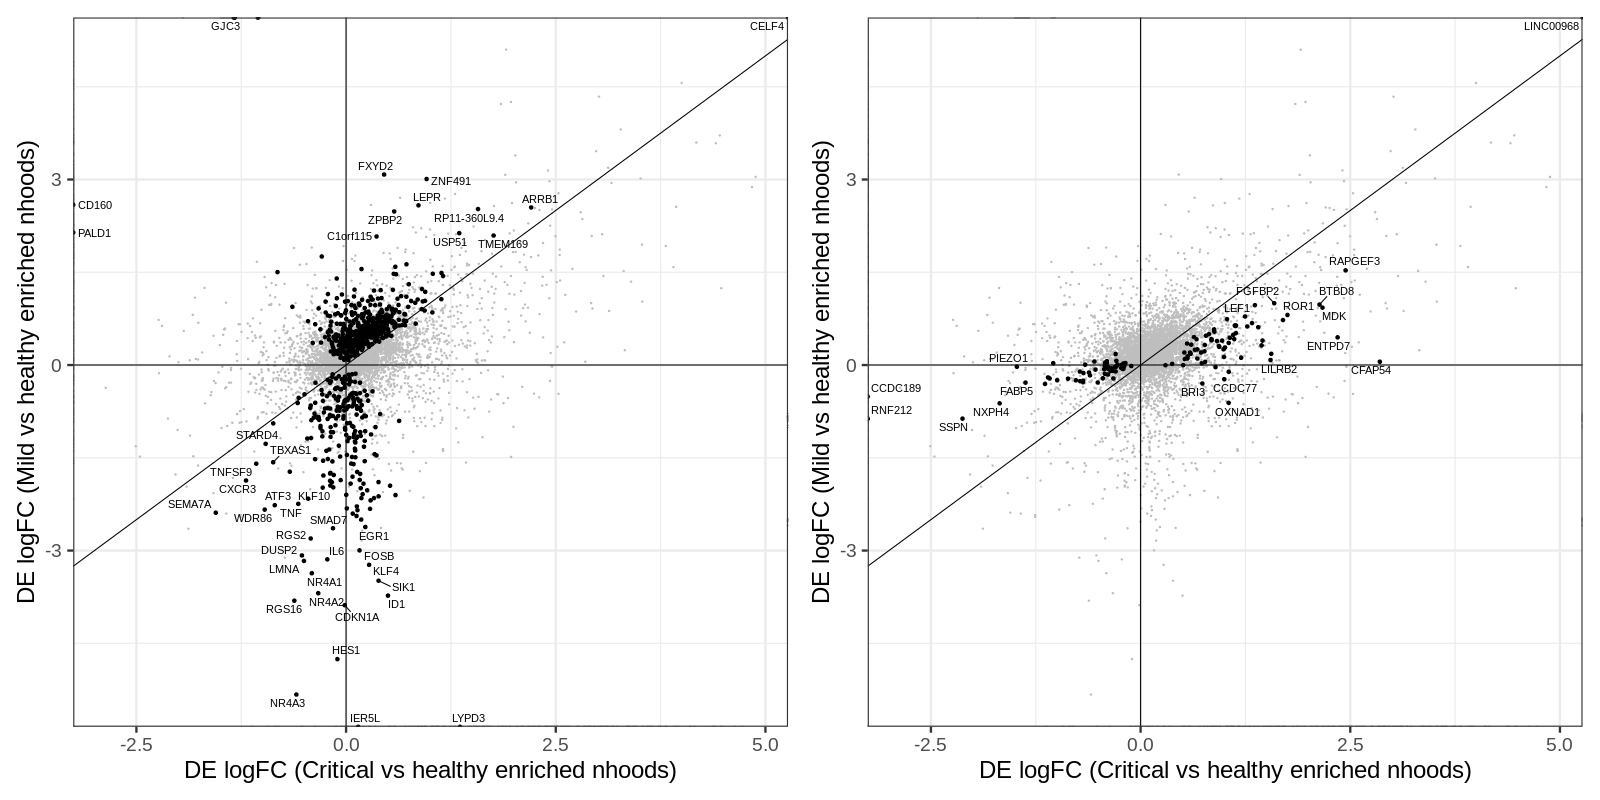

In [150]:
%%R -w 1600 -h 800
mild_specific_pl + crit_specific_pl

#### Enrichment analysis

In [134]:
import gseapy as gp
from gseapy.plot import barplot, dotplot

def run_enrichr(DE_results, alpha=0.1, 
                min_lfc = 0,
                outdir = resdir + 'enrichr/Bnaive/', gene_sets=['MSigDB_Hallmark_2020']):
    names = gp.get_library_name()

    up_genes = DE_results[(DE_results.adj_pval < alpha) & (DE_results.lfc > min_lfc)].index
    down_genes = DE_results[(DE_results.adj_pval < alpha) & (DE_results.lfc < - min_lfc)].index

    bg_genes = DE_results.index.unique()

    enr_up = gp.enrichr(gene_list=up_genes.tolist(),
                             gene_sets=gene_sets,
                             organism='Human', 
                             background=bg_genes.tolist(),
                             outdir=outdir + '/up_genes/',
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            ).results
    enr_down = gp.enrichr(gene_list=down_genes.tolist(),
                             gene_sets=gene_sets,
                             organism='Human', 
                             background=bg_genes.tolist(),
                             outdir=outdir + '/down_genes/',
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            ).results
    return(enr_up, enr_down)
    

In [180]:
signif_crit = DE_Bnaive.gene_name[(DE_Bnaive.adj_pval < 0.1) & (DE_Bnaive.contrast == 'critical_enr-other')].values
signif_mild = DE_Bnaive.gene_name[(DE_Bnaive.adj_pval < 0.1) & (DE_Bnaive.contrast == 'mild_enr-other')].values

signif_both = np.intersect1d(signif_crit, signif_mild)
signif_crit_only = np.setdiff1d(signif_crit, signif_mild)
signif_mild_only = np.setdiff1d(signif_mild, signif_crit)

In [360]:
enr_mild_up, enr_mild_down = run_enrichr(DE_Bnaive[DE_Bnaive.contrast == 'mild_enr-other'].loc[signif_mild_only], 
                                         min_lfc= 0,
                                         outdir = resdir + 'enrichr/Bnaive_mild/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])
enr_crit_up, enr_crit_down = run_enrichr(DE_Bnaive[DE_Bnaive.contrast == 'critical_enr-other'].loc[signif_crit_only], 
                                         min_lfc= 0,
                                         outdir = resdir + 'enrichr/Bnaive_critical/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:4d85f90bafa4062d20ac9795417907b3
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:9d2a5db49b29650a14a1e95b42e1845c
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:d4d567aa6f284415f849d19cec642ea6
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:d9784bcd4af2f31b25d0a2508a75a97e
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:a8be51f42606ff8f0b1add11c3688b5f
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:d0fcd5a50bdb1aa3e77bcffadaf465c9
Done.

C

In [361]:
enr_crit_up[enr_crit_up['Adjusted P-value'] < 0.1]

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0   positive regulation of angiogenesis (GO:0045766)   5/116  0.000044   
1  positive regulation of vasculature development...   4/102  0.000382   
2  positive regulation of T cell differentiation ...    3/43  0.000403   
3            regulation of angiogenesis (GO:0045765)   5/203  0.000594   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.024519            0                     0   14.401337   
1          0.075476            0                     0   12.850664   
2          0.075476            0                     0   23.312109   
3          0.083523            0                     0    8.038042   

   Combined Score                             Genes  
0      144.586398       BTG1;MDK;GAB1;HIPK1;RAPGEF3  
1      101.138092           BTG1;GAB1;HIPK1;RAPGEF3  
2      182.226730                   MDK;LEF1;LILRB2  
3       59.705333  BTG1;SERPINF1;GAB1;HIPK1;RAPGEF3

In [362]:
enr_crit_down[enr_crit_down['Adjusted P-value'] < 0.1]

Gene_set  \
0    GO_Biological_Process_2021   
1    GO_Biological_Process_2021   
2    GO_Biological_Process_2021   
3    GO_Biological_Process_2021   
4    GO_Biological_Process_2021   
..                          ...   
662        MSigDB_Hallmark_2020   
663        MSigDB_Hallmark_2020   
664        MSigDB_Hallmark_2020   
665        MSigDB_Hallmark_2020   
666        MSigDB_Hallmark_2020   

                                                  Term Overlap       P-value  \
0                neutrophil degranulation (GO:0043312)  10/481  9.247618e-07   
1    neutrophil activation involved in immune respo...  10/485  9.967193e-07   
2            neutrophil mediated immunity (GO:0002446)  10/488  1.053858e-06   
3    interferon-gamma-mediated signaling pathway (G...    5/68  1.428368e-06   
4            cell projection organization (GO:0030030)    4/30  1.536978e-06   
..                                                 ...     ...           ...   
662                                   mTORC1 Signaling   4/200  2.534140e-03   
663                            Cholesterol Homeostasis    2/74  1.890418e-02   
664                               IL-2/STAT5 Signaling   3/199  1.915828e-02   
665                                    Apical Junction   3/200  1.941144e-02   
666                                         Complement   3/200  1.941144e-02   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0            0.000203            0                     0    8.796133   
1            0.000203            0                     0    8.720269   
2            0.000203            0                     0    8.664204   
3            0.000203            0                     0   30.341880   
4            0.000203            0                     0   57.814224   
..                ...          ...                   ...         ...   
662          0.025341            0                     0    7.603774   
663          0.083192            0                     0   10.035859   
664          0.083192            0                     0    5.597222   
665          0.083192            0                     0    5.568528   
666          0.083192            0                     0    5.568528   

     Combined Score                                              Genes  
0        122.211096  PLAC8;FABP5;NME2;COTL1;CTSH;NCKAP1L;CD68;DYNLL...  
1        120.503621  PLAC8;FABP5;NME2;COTL1;CTSH;NCKAP1L;CD68;DYNLL...  
2        119.245894  PLAC8;FABP5;NME2;COTL1;CTSH;NCKAP1L;CD68;DYNLL...  
3        408.370693                HLA-DRA;HLA-A;B2M;HLA-DQA1;HLA-DPA1  
4        773.883425                             PLEK;RAC2;CAPG;NCKAP1L  
..              ...                                                ...  
662       45.454605                            ACTR3;PRDX1;PPIA;CORO1A  
663       39.826025                                        FABP5;ACTG1  
664       22.137126                                      CD48;CAPG;LTB  
665       21.950538                                    RAC2;PFN1;ACTG1  
666       21.950538                                     PLEK;CTSH;PFN1  

[234 rows x 10 columns]

In [363]:
enr_mild_up[enr_mild_up['Adjusted P-value'] < 0.1]

Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   
20  GO_Biological_Process_2021   
21  GO_Biological_Process_2021   
22  GO_Biological_Process_2021   
23  GO_Biological_Process_2021   
24  GO_Biological_Process_2021   
25  GO_Biological_Process_2021   
26  GO_Biological_Process_2021   
27  GO_Biological_Process_2021   
28  GO_Biological_Process_2021   
29  GO_Biological_Process_2021   
30  GO_Biological_Process_2021   
31  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0              nuclear mRNA surveillance (GO:0071028)    4/10  0.000051   
1                   B cell proliferation (GO:0042100)    6/32  0.000075   
2   nuclear retention of pre-mRNA at the site of t...     3/5  0.000115   
3   maturation of 5.8S rRNA from tricistronic rRNA...    5/22  0.000116   
4   cellular response to oxidative stress (GO:0034...  11/125  0.000141   
5   regulation of B cell receptor signaling pathwa...    5/23  0.000146   
6   nuclear-transcribed mRNA catabolic process (GO...  13/171  0.000159   
7                      tRNA surveillance (GO:0106354)     3/6  0.000225   
8    negative regulation of ERAD pathway (GO:1904293)     3/6  0.000225   
9   nuclear polyadenylation-dependent ncRNA catabo...     3/6  0.000225   
10  nuclear polyadenylation-dependent rRNA catabol...     3/6  0.000225   
11  nuclear polyadenylation-dependent tRNA catabol...     3/6  0.000225   
12  positive regulation of lymphocyte proliferatio...    8/75  0.000309   
13  B cell activation involved in immune response ...    4/16  0.000394   
14               ncRNA catabolic process (GO:0034661)    5/30  0.000542   
15  positive regulation of B cell proliferation (G...    5/30  0.000542   
16    regulation of B cell proliferation (GO:0030888)    6/46  0.000595   
17  alternative mRNA splicing, via spliceosome (GO...    4/18  0.000638   
18                rRNA catabolic process (GO:0016075)    4/18  0.000638   
19  positive regulation of neutrophil chemotaxis (...    4/19  0.000794   
20  vascular endothelial growth factor receptor si...    7/67  0.000828   
21  exonucleolytic trimming involved in rRNA proce...     3/9  0.000898   
22  exonucleolytic trimming to generate mature 3'-...     3/9  0.000898   
23                      response to UV-C (GO:0010225)     3/9  0.000898   
24              nuclear RNA surveillance (GO:0071027)     3/9  0.000898   
25     B cell receptor signaling pathway (GO:0050853)    5/34  0.000981   
26  regulation of myoblast differentiation (GO:004...    5/34  0.000981   
27  phosphatidylinositol 3-kinase signaling (GO:00...    5/34  0.000981   
28                   protein prenylation (GO:0018342)    3/10  0.001262   
29  immunoglobulin mediated immune response (GO:00...    3/10  0.001262   
30                rRNA 3'-end processing (GO:0031125)    3/10  0.001262   
31                rRNA metabolic process (GO:0016072)  11/162  0.001278   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.046500            0                     0   28.752024   
1           0.046500            0                     0    9.986526   
2           0.046500            0                     0   64.562775   
3           0.046500            0                     0   12.705622   
4           0.046500            0                     0    4.203426 

In [364]:
enr_mild_down[enr_mild_down['Adjusted P-value'] < 0.1]

Gene_set  \
0     GO_Biological_Process_2021   
1     GO_Biological_Process_2021   
2     GO_Biological_Process_2021   
3     GO_Biological_Process_2021   
4     GO_Biological_Process_2021   
...                          ...   
2058        MSigDB_Hallmark_2020   
2059        MSigDB_Hallmark_2020   
2060        MSigDB_Hallmark_2020   
2061        MSigDB_Hallmark_2020   
2062        MSigDB_Hallmark_2020   

                                                   Term  Overlap  \
0     positive regulation of transcription by RNA po...   37/908   
1                 regulation of cell cycle (GO:0051726)   19/296   
2     positive regulation of transcription, DNA-temp...  39/1183   
3     negative regulation of transcription by RNA po...   28/684   
4          regulation of apoptotic process (GO:0042981)   28/742   
...                                                 ...      ...   
2058                                       Adipogenesis    7/200   
2059                                         Complement    7/200   
2060                                     Myc Targets V1    7/200   
2061                                    G2-M Checkpoint    6/200   
2062                                  KRAS Signaling Dn    6/200   

           P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     1.104670e-11      2.252423e-08            0                     0   
1     1.242022e-09      9.914097e-07            0                     0   
2     1.458670e-09      9.914097e-07            0                     0   
3     4.156281e-09      2.118664e-06            0                     0   
4     2.397576e-08      9.485842e-06            0                     0   
...            ...               ...          ...                   ...   
2058  7.811790e-03      1.633374e-02            0                     0   
2059  7.811790e-03      1.633374e-02            0                     0   
2060  7.811790e-03      1.633374e-02            0                     0   
2061  2.638769e-02      5.057640e-02            0                     0   
2062  2.638769e-02      5.057640e-02            0                     0   

      Odds Ratio  Combined Score  \
0       4.248665      107.189101   
1       6.460577      132.483974   
2       3.396330       69.100841   
3       4.121274       79.534999   
4       3.775005       66.237076   
...          ...             ...   
2058    3.242885       15.734869   
2059    3.242885       15.734869   
2060    3.242885       15.734869   
2061    2.752577       10.005227   
2062    2.752577       10.005227   

                                                  Genes  
0     ARF4;CSRNP1;DDX3X;CITED2;TNF;UBC;EPC1;HES1;KAT...  
1     TSPYL2;PPP1R15A;JUN;CDKN1A;JUND;HSP90AB1;GADD4...  
2     ARF4;CSRNP1;DDX3X;CITED2;TNF;SERTAD1;UBC;EPC1;...  
3     DDX5;CITED2;ZBTB1;TNF;ZFP36;UBC;ZNF669;EPC1;HE...  
4     ARF4;PRR7;DDX3X;ARL6IP1;CITED2;TNF;LGALS1;UBC;...  
...                                                 ...  
2058          PPP1R15B;ARL4A;UBC;DNAJB9;PLIN2;PIM3;TOB1  
2059            DUSP5;IL6;HSPA5;IRF1;PIM1;TNFAIP3;DUSP6  
2060     EIF4A1;SLC25A3;HSP90AB1;TRA2B;IFRD1;ODC1;SRSF7  
2061                    SFPQ;DBF4;UBE2S;TRA2B;ODC1;CKS2  
2062                  NR4A2;BTG2;LYPD3;SGK1;SKIL;TENT5C  

[392 rows x 10 columns]

In [143]:
pl_genes = enr_mild_up.iloc[5].Genes.split(';')

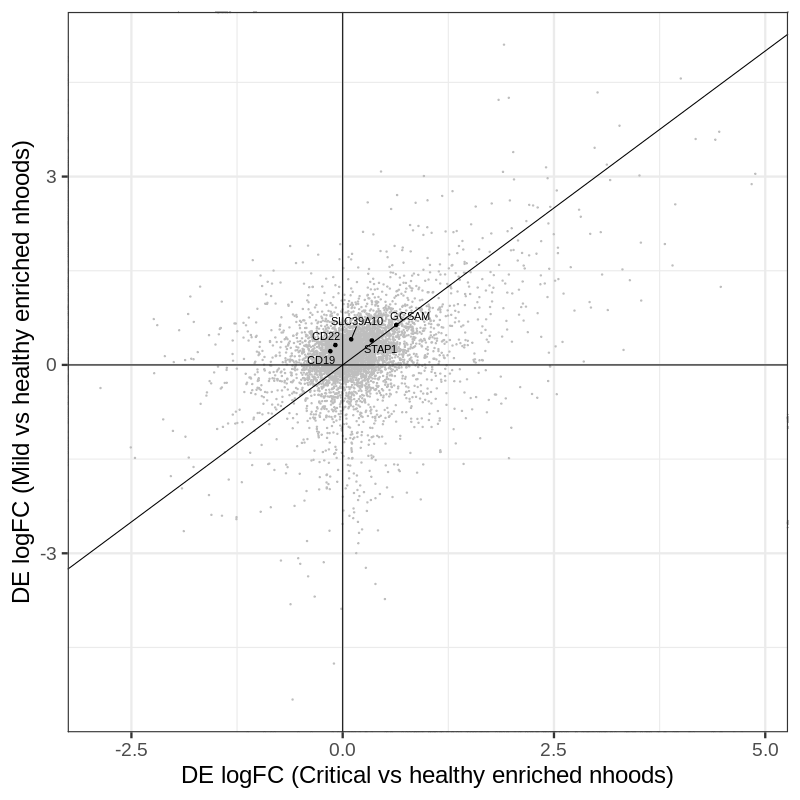

In [144]:
%%R -w 800 -h 800 -i pl_genes
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse(as.character(gene_name) %in% unlist(pl_genes), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

In [348]:
enr_mild_up, enr_mild_down = run_enrichr(DE_Bnaive[DE_Bnaive.contrast == 'mild_enr-other'].loc[signif_mild_only], 
                                         min_lfc= 1.0,
                                         outdir = resdir + 'enrichr/Bnaive_mild_highLFC/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:f3d241a1f3b1971a24a9a8f1f94d0066
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:9a45dad5477fcc49929fc19f10b3fdfe
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:09c105e189e69f7f3e8eaabce82255eb
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:855b33c401a265b67fa48405b9195b15
Done.



In [345]:
enr_mild_up.iloc[2]["Genes"]

'ZNF551;ZNF17;SPAG8;PLAG1;ZNF491;LMO7;ARRB1;SOX12;ZNF75D;BCLAF3;ZNF41;ZNF558;ZNF525;KMT5A;ZNF585B;ZNF575'

In [366]:
enr_mild_up[enr_mild_up['Adjusted P-value'] < 0.1][['Term', 'Adjusted P-value', "Genes"]]

Term  Adjusted P-value  \
0              nuclear mRNA surveillance (GO:0071028)          0.046500   
1                   B cell proliferation (GO:0042100)          0.046500   
2   nuclear retention of pre-mRNA at the site of t...          0.046500   
3   maturation of 5.8S rRNA from tricistronic rRNA...          0.046500   
4   cellular response to oxidative stress (GO:0034...          0.046500   
5   regulation of B cell receptor signaling pathwa...          0.046500   
6   nuclear-transcribed mRNA catabolic process (GO...          0.046500   
7                      tRNA surveillance (GO:0106354)          0.046500   
8    negative regulation of ERAD pathway (GO:1904293)          0.046500   
9   nuclear polyadenylation-dependent ncRNA catabo...          0.046500   
10  nuclear polyadenylation-dependent rRNA catabol...          0.046500   
11  nuclear polyadenylation-dependent tRNA catabol...          0.046500   
12  positive regulation of lymphocyte proliferatio...          0.058878   
13  B cell activation involved in immune response ...          0.069673   
14               ncRNA catabolic process (GO:0034661)          0.083244   
15  positive regulation of B cell proliferation (G...          0.083244   
16    regulation of B cell proliferation (GO:0030888)          0.083244   
17  alternative mRNA splicing, via spliceosome (GO...          0.083244   
18                rRNA catabolic process (GO:0016075)          0.083244   
19  positive regulation of neutrophil chemotaxis (...          0.086846   
20  vascular endothelial growth factor receptor si...          0.086846   
21  exonucleolytic trimming involved in rRNA proce...          0.086846   
22  exonucleolytic trimming to generate mature 3'-...          0.086846   
23                      response to UV-C (GO:0010225)          0.086846   
24              nuclear RNA surveillance (GO:0071027)          0.086846   
25     B cell receptor signaling pathway (GO:0050853)          0.086846   
26  regulation of myoblast differentiation (GO:004...          0.086846   
27  phosphatidylinositol 3-kinase signaling (GO:00...          0.086846   
28                   protein prenylation (GO:0018342)          0.098985   
29  immunoglobulin mediated immune response (GO:00...          0.098985   
30                rRNA 3'-end processing (GO:0031125)          0.098985   
31                rRNA metabolic process (GO:0016072)          0.098985   

                                                Genes  
0                           EXOSC7;PCID2;EXOSC10;XRN1  
1                    CD40;MEF2C;PTPRC;CD19;CD180;GAPT  
2                                PCID2;EXOSC10;EXOSC3  
3                     EXOSC7;EXOSC10;PES1;RRS1;EXOSC3  
4   PRKAA1;PINK1;NCF1;GSTP1;PXN;AKT1;CYBB;MAPK1;PY...  
5                      CD19;SLC39A10;STAP1;GCSAM;CD22  
6   TUT4;UPF3B;RPL35A;ZFP36L1;CNOT4;EXOSC7;PAN3;EX...  
7                               EXOSC7;EXOSC10;EXOSC3  
8                                    USP14;USP25;SVIP  
9                               EXOSC7;EXOSC10;EXOSC3  
10                              EXOSC7;EXOSC10;EXOSC3  
11                              EXOSC7;EXOSC10;EXOSC3  
12       VAV3;CD74;CD40;MEF2C;HLA-DMB;PTPRC;IL15;NCK2  
13                             CD19;CD180;EXOSC3;GAPT  
14                    EXOSC7;EXOSC10;XRN1;TUT4;EXOSC3  
15                         VAV3;CD74;CD40;MEF2C;PTPRC  
16                    VAV3;CD74;CD40;MEF2C;PTPRC;CD22  
17                            DDX17;RSRC1;CELF4;CDK13  
18                         EXOSC7;EXOSC10;XRN1;EXOSC3  
19                            CD74;RIPOR2;CAMK1D;RAC1  
20                VAV3;NCF1;PXN;NCK2;CYBB;RAC1;MAPK14  
21                              EXOSC7;EXOSC10;EXOSC3  
22                              EXOSC7;EXOSC10;EXOSC3  
23                                  ERCC5;MAP3K4;POLH  
24                                EXOSC7;EXOSC10;XRN1  
25                      VAV3;MEF2C;PTPRC;PLEKHA1;CD19  
26                  RIPOR2;MEF2C;MAPK14;EID2B;ZFP36L1  
27   

#### Plot gex

In [356]:
df = DE_Bnaive[DE_Bnaive.contrast == 'mild_enr-other'].loc[signif_mild_only]
signif_mild_only_up = df.index[df.lfc > 0]
signif_mild_only_down = df.index[df.lfc < 0]
signif_mild_only_up.shape

(457,)

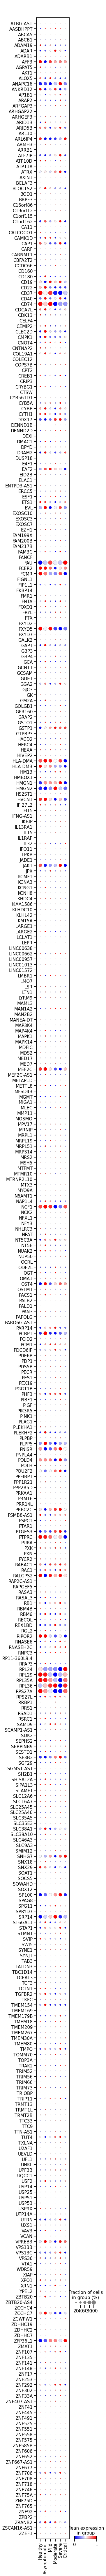

In [359]:
sdata = adata[(adata.obs['author_cell_type'] == 'B_naive') & (adata.obs['severity_cont'] >= 0) ]
sdata.obs['Status_on_day_collection_summary'] = sdata.obs['Status_on_day_collection_summary'].cat.reorder_categories(order_severity)
sc.pl.dotplot(sdata, 
              signif_mild_only_up, 
              groupby='Status_on_day_collection_summary', standard_scale='var', cmap='bwr', swap_axes=True)

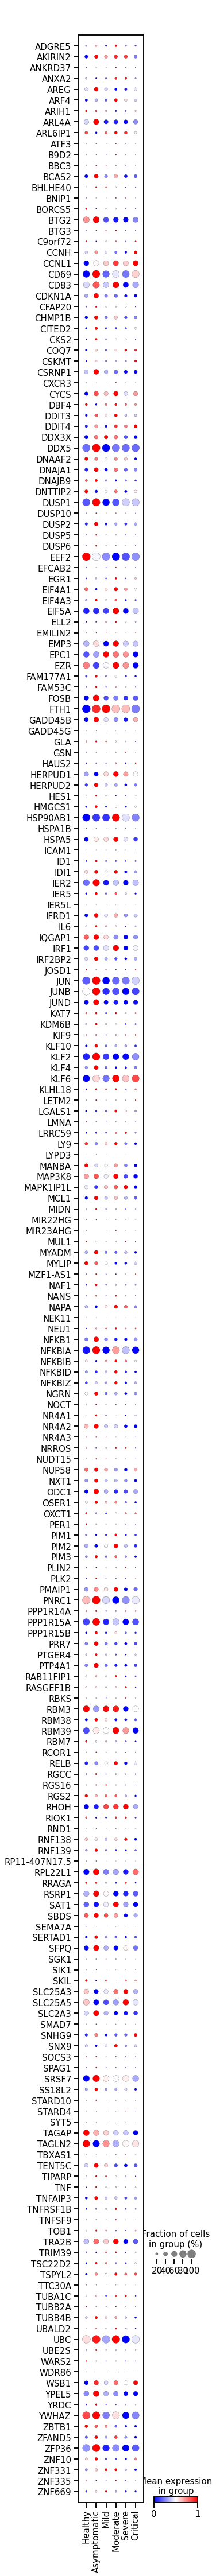

In [365]:
sdata = adata[(adata.obs['author_cell_type'] == 'B_naive') & (adata.obs['severity_cont'] >= 0) ]
sdata.obs['Status_on_day_collection_summary'] = sdata.obs['Status_on_day_collection_summary'].cat.reorder_categories(order_severity)
sc.pl.dotplot(sdata, 
              signif_mild_only_down, 
              groupby='Status_on_day_collection_summary', standard_scale='var', cmap='bwr', swap_axes=True)

#### Dependency on Days since onset

<AxesSubplot:xlabel='Days_from_onset', ylabel='nhood_groups'>

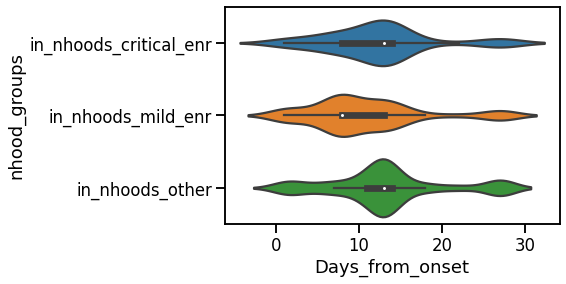

In [394]:
df = adata[adata.obs['author_cell_type'] == 'B_naive'].obs[['nhood_groups', 'severity_cont', 'Days_from_onset']]
df = df[df['severity_cont'] == 2]
df.Days_from_onset = df.Days_from_onset.astype('str').astype('int')
sns.violinplot(data=df, y='nhood_groups', x='Days_from_onset')
# sc.pl.violin(adata[(adata.obs['author_cell_type'] == 'B_naive') & (adata.obs['severity_cont'] == 2)], 'Days_from_onset', groupby='nhood_groups')

In [415]:
df = adata.obs[['nhood_groups', 'severity_cont', 'Days_from_onset', 'donor_id', 'author_cell_type']].copy()
df = df[df['author_cell_type'] == 'B_naive']
df = df.groupby(['donor_id', 'Days_from_onset', 'severity_cont', 'nhood_groups']).size().reset_index()
df = df[df[0] > 0]
df.columns = ['donor_id', 'Days_from_onset', 'severity_cont', 'nhood_groups', 'n_cells']

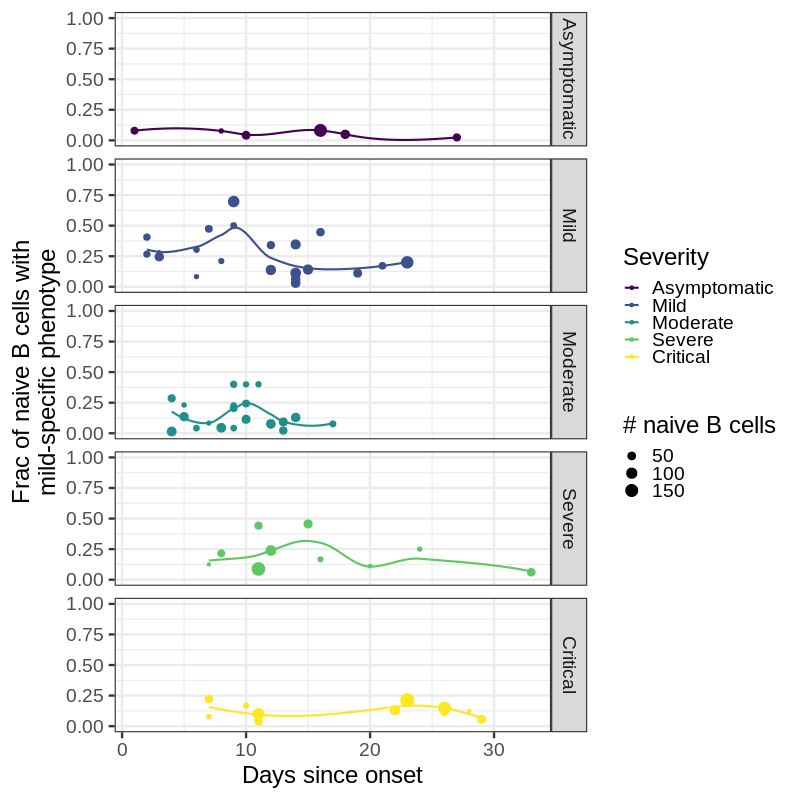

In [476]:
%%R -i df -w 800 -h 800
df %>%
filter(severity_cont > 0) %>%
filter(!Days_from_onset %in% c("Healthy", 'Not_known')) %>%
arrange(as.numeric(Days_from_onset)) %>%
group_by(donor_id) %>%
mutate(frac_Bnaive = n_cells/sum(n_cells), n_Bnaive=sum(n_cells)) %>% 
mutate(donor_id =factor(donor_id, levels=unique(donor_id))) %>%
filter(nhood_groups == 'in_nhoods_mild_enr') %>%
filter(n_Bnaive >= 5) %>%
mutate(Severity = unlist(order_severity)[2:length(order_severity)][severity_cont]) %>%
mutate(Severity = factor(Severity, levels=order_severity)) %>%
ggplot(aes(as.numeric(Days_from_onset), frac_Bnaive, color=Severity)) +
geom_point(aes(size=n_Bnaive)) +
geom_smooth(se=F) +
theme_bw(base_size=24) +
facet_grid(Severity~.) +
ylim(0,1) +
scale_color_viridis_d() +
scale_size(name='# naive B cells') +
xlab('Days since onset') + ylab("Frac of naive B cells with\nmild-specific phenotype")

In [519]:
df = adata.obs[['severity_cont', 'Days_from_onset', 'donor_id', 'author_cell_type']].copy()
df = df[df['author_cell_type'].isin(anno_groups["monos"])]
df = df.groupby(['donor_id', 'Days_from_onset', 'severity_cont', 'author_cell_type']).size().reset_index()
df = df[df[0] > 0]
df.columns = ['donor_id', 'Days_from_onset', 'severity_cont', 'author_cell_type','n_cells']
df

donor_id Days_from_onset  severity_cont author_cell_type  n_cells
7250             AP1              28              4        CD14_mono       16
7251             AP1              28              4        CD16_mono        8
7267             AP1              28              4   CD83_CD14_mono       68
18623            AP2              47              5        CD14_mono       13
18624            AP2              47              5        CD16_mono        8
...              ...             ...            ...              ...      ...
1190365  newcastle65         Healthy              0   CD83_CD14_mono       23
1200445  newcastle74         Healthy              0     C1_CD16_mono        1
1200446  newcastle74         Healthy              0        CD14_mono       15
1200447  newcastle74         Healthy              0        CD16_mono       16
1200463  newcastle74         Healthy              0   CD83_CD14_mono       15

[351 rows x 5 columns]

`summarise()` has grouped output by 'donor_id', 'severity_cont'. You can override using the `.groups` argument.


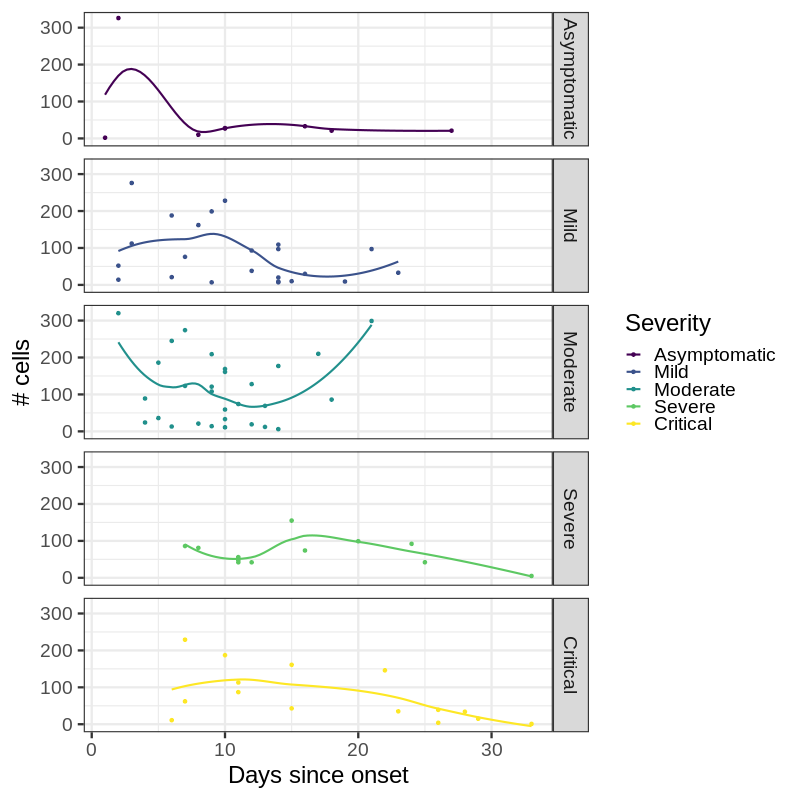

In [520]:
%%R -i df -w 800 -h 800
df %>%
filter(severity_cont > 0) %>%
filter(!Days_from_onset %in% c("Healthy", 'Not_known')) %>%
# filter(author_cell_type == 'NK_16hi') %>%
# head()
mutate
arrange(as.numeric(Days_from_onset)) %>%
group_by(donor_id, severity_cont, Days_from_onset) %>%
summarise(n_Bnaive=sum(n_cells)) %>% 
mutate(donor_id =factor(donor_id, levels=unique(donor_id))) %>%
mutate(Severity = unlist(order_severity)[2:length(order_severity)][severity_cont]) %>%
mutate(Severity = factor(Severity, levels=order_severity)) %>%
ggplot(aes(as.numeric(Days_from_onset), n_Bnaive, color=Severity)) +
geom_point() +
geom_smooth(se=F) +
theme_bw(base_size=24) +
facet_grid(Severity~.) +
# ylim(0,1) 
scale_color_viridis_d() +
xlab('Days since onset') + ylab("# cells")

In [551]:
sdata = adata[(adata.obs['severity_cont'] >= 1) & (~adata.obs['Days_from_onset'].isin(['Healthy', 'Not_known', 'nan']))]
sdata.obs['Status_on_day_collection_summary'] = sdata.obs['Status_on_day_collection_summary'].cat.reorder_categories(order_severity[1:])
sdata.obs['Days_from_onset'] = sdata.obs['Days_from_onset'].astype('str').astype('int')
df = sdata.obs[['IFN_signature','Days_from_onset', 'author_cell_type', 'donor_id', 'severity_cont']]
df['anno_group'] = [anno_group_rev[x] for x in df['author_cell_type']]
df = df.groupby(['anno_group', 'Days_from_onset', 'donor_id', 'severity_cont']).mean('IFN_signature').reset_index()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


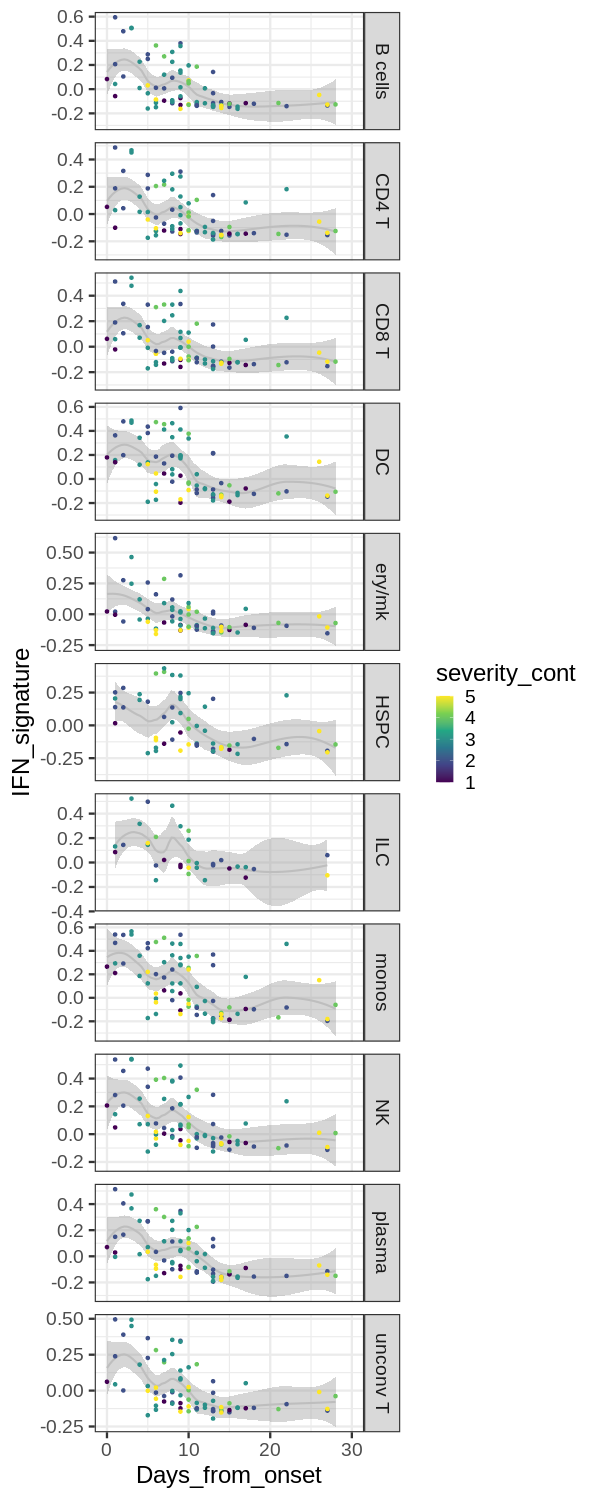

In [572]:
%%R -i df -w 600 -h 1500
df %>%
ggplot(aes(Days_from_onset, IFN_signature, color=severity_cont)) +
geom_smooth(color='grey', span = 0.5, method='loess') +
geom_point() +
facet_grid(anno_group~., scales='free_y') +
scale_color_viridis_c() +
theme_bw(base_size=24) +
xlim(0,30)

In [582]:
adata.obs['anno_group'] = [anno_group_rev[x] for x in adata.obs['author_cell_type']]
df = adata.obs[['IFN_signature', 'anno_group', "severity_cont"]].groupby(['anno_group', "severity_cont"]).mean('IFN_signature').reset_index()

In [583]:
%%R -i df
head(df)

  anno_group severity_cont IFN_signature
1    B cells            -1   -0.10712225
2    B cells             0   -0.13860538
3    B cells             1   -0.06780200
4    B cells             2   -0.01843444
5    B cells             3    0.07545735
6    B cells             4    0.01963046


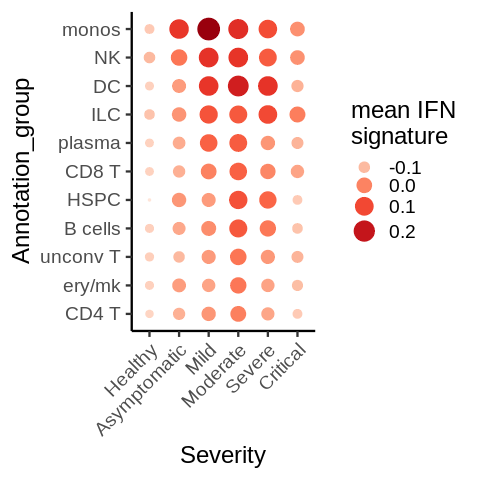

In [603]:
%%R 
df %>%
filter(severity_cont >= 0) %>%
mutate(Severity = unlist(order_severity)[severity_cont+1]) %>%
mutate(Severity = factor(Severity, levels=order_severity)) %>%
group_by(anno_group) %>%
mutate(m=mean(IFN_signature)) %>%
ungroup() %>%
arrange(m) %>%
mutate(anno_group = factor(anno_group, levels=unique(anno_group))) %>%
ggplot(aes(Severity, anno_group)) +
geom_point(aes(size=IFN_signature, color=IFN_signature)) +
scale_color_distiller(palette='Reds', direction=1, name='mean IFN\nsignature') +
theme_classic(base_size=24) +
scale_size(range=c(1,10), name='mean IFN\nsignature') +
guides(color= guide_legend(), size=guide_legend())+
ylab('Annotation_group') +
theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

### Low IFN and specific to advanced disease - NK

In [608]:
logFC_df = nhood_adata.obs[ [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
logFC_df = logFC_df.dropna()
logFC_df['nhood_id'] = logFC_df.index.copy()
nhood_order = logFC_df.sort_values('logFC_Critical')['nhood_id'].values

FDR_df = nhood_adata.obs[ [f'SpatialFDR_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
FDR_df = FDR_df.dropna()
FDR_df['nhood_id'] = FDR_df.index.copy()

## scale logFC for each test
lfc_df = logFC_df[[f'logFC_{sev}' for sev in order_severity[1:]]]
scaled_lfc_df = lfc_df/lfc_df.std(0)
logFC_df.loc[:,[f'logFC_{sev}' for sev in order_severity[1:]]] = scaled_lfc_df

## Select nhoods with at least one signif DA
signif_nhoods = (FDR_df[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0
lfc_df = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_id']]

lfc_df = lfc_df.loc[order_index]

## Make cell type identity heatmap (1/0)
dummy_anno_df = logFC_df[['nhood_annotation', 'nhood_id']].loc[order_index]
dummy_anno_df['anno_group'] = [anno_group_rev[x] for x in dummy_anno_df['nhood_annotation']]
anno_group_order = list(anno_group_order)

lfc_df = pd.merge(lfc_df, dummy_anno_df)
lfc_df

logFC_Asymptomatic  logFC_Mild  logFC_Moderate  logFC_Severe  \
0              -0.643331    1.365259        0.908265      0.785217   
1               0.771672    1.257700        0.840087      0.711407   
2               0.142558    0.930505        0.703720      0.465286   
3               1.135137    0.333982        0.499920      0.027060   
4               0.576815    0.388620        0.049313     -0.373632   
...                  ...         ...             ...           ...   
1628           -1.700730   -1.535745       -1.412362     -1.326208   
1629           -1.485686   -1.767079       -1.491987     -1.405349   
1630           -1.543066   -1.853977       -1.295473     -1.702468   
1631           -1.699038   -2.071097       -1.375262     -1.318493   
1632           -1.379872   -1.740838       -1.183171     -1.102078   

      logFC_Critical nhood_id nhood_annotation anno_group  
0           6.096818     1424      B_malignant    B cells  
1           6.154769     1431      B_malignant    B cells  
2           6.129770     1452      B_malignant    B cells  
3           5.458437     1429      B_malignant    B cells  
4           5.335318     1456      B_malignant    B cells  
...              ...      ...              ...        ...  
1628       -0.695261     3909   CD83_CD14_mono      monos  
1629       -0.834786     4111   CD83_CD14_mono      monos  
1630       -1.049069     4285   CD83_CD14_mono      monos  
1631       -0.363197     3652          NK_16hi         NK  
1632       -0.107615     4379   CD83_CD14_mono      monos  

[1633 rows x 8 columns]

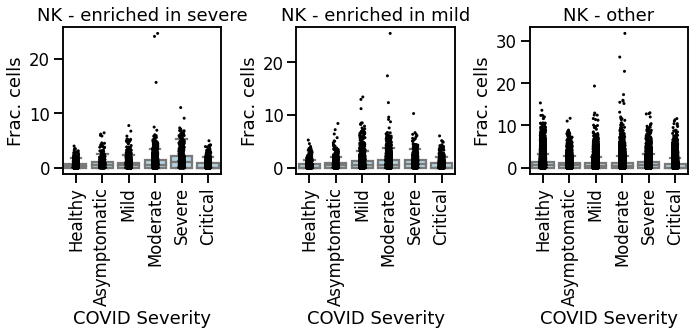

In [680]:
severe_nk_nhoods_all = FDR_df[((nhood_adata.obs['SpatialFDR_Critical'] < 0.1) | (nhood_adata.obs['SpatialFDR_Severe'] < 0.1)) &
       ((nhood_adata.obs['logFC_Critical'] > 0) & (nhood_adata.obs['logFC_Severe'] > 0)) &
      nhood_adata.obs['nhood_annotation'].isin(anno_groups['NK'])
      ].nhood_id.values

mild_nk_nhoods = FDR_df[((nhood_adata.obs['SpatialFDR_Asymptomatic'] < 0.1) | (nhood_adata.obs['SpatialFDR_Mild'] < 0.1) | (nhood_adata.obs['SpatialFDR_Moderate'] < 0.1)) &
       ((nhood_adata.obs['logFC_Asymptomatic'] > 0) & (nhood_adata.obs['logFC_Mild'] > 0) & (nhood_adata.obs['logFC_Moderate'] > 0)) &
      nhood_adata.obs['nhood_annotation'].isin(anno_groups['NK'])
      ].nhood_id.values

severe_nk_nhoods = np.setdiff1d(severe_nk_nhoods_all, mild_nk_nhoods)
other_nk_nhoods = np.setdiff1d(FDR_df[nhood_adata.obs['nhood_annotation'].isin(anno_groups['NK'])].nhood_id.values, np.union1d(severe_nk_nhoods, mild_nk_nhoods))


with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,3,1);
    plot_nhood_counts_by_severity(nhood_adata, severe_nk_nhoods, normalize=True);
    plt.title("NK - enriched in severe");
    plt.subplot(1,3,2);
    plot_nhood_counts_by_severity(nhood_adata, mild_nk_nhoods, normalize=True);
    plt.title("NK - enriched in mild")
    plt.subplot(1,3,3);
    plot_nhood_counts_by_severity(nhood_adata, other_nk_nhoods, normalize=True);
    plt.title("NK - other")
    plt.tight_layout()

In [681]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[mild_nk_nhoods, 'nhood_groups'] = 'mild_enr'
nhood_adata.obs.loc[severe_nk_nhoods, 'nhood_groups'] = 'severe_enr'
nhood_adata.obs.loc[other_nk_nhoods, 'nhood_groups'] = 'other'
adata.uns['nhood_adata'] = nhood_adata.copy()

In [682]:
adata.obs['nhood_groups'].value_counts()

in_nhoods_other         10105
in_nhoods_mild_enr        166
in_nhoods_severe_enr      143
Name: nhood_groups, dtype: int64

In [715]:
nk_adata = adata[adata.obs['author_cell_type'].isin(anno_groups['NK'])].copy()
nk_adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(nk_adata, groupby='nhood_groups', groups=['in_nhoods_mild_enr', 'in_nhoods_severe_enr'])

... storing 'nhood_groups' as categorical
... storing 'anno_group' as categorical


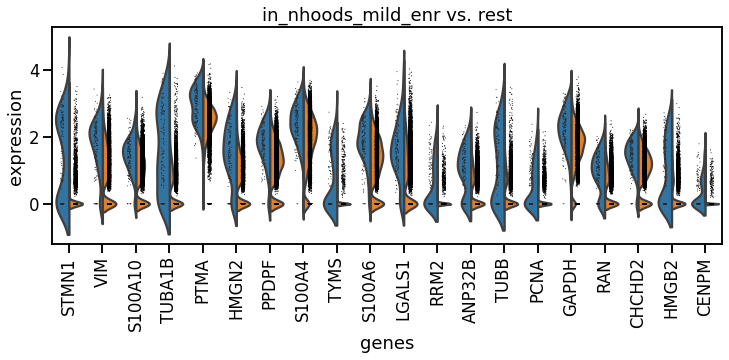

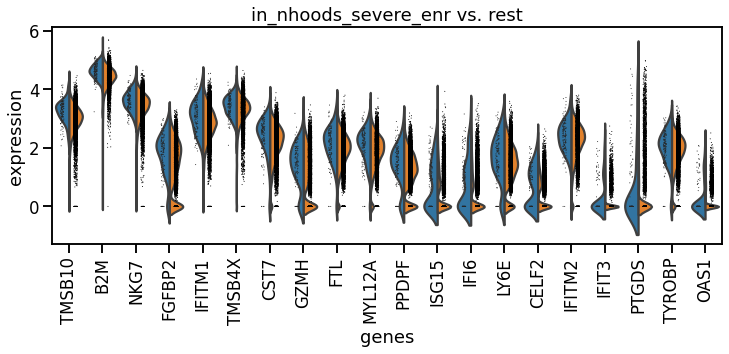

In [716]:
ifn_signature_genes = [
    'BST2', 'CMPK2', 'EIF2AK2', 'EPSTI1', 'HERC5', 'IFI35', 'IFI44L', 'IFI6', 
    'IFIT3', 'ISG15', 'LY6E', 'MX1', 'MX2', 'OAS1', 'OAS2', 'PARP9', 'PLSCR1', 
    'SAMD9', 'SAMD9L', 'SP110', 'STAT1', 'TRIM22', 'UBE2L6', 'XAF1', 'IRF7'
    ]

with rc_context({'figure.figsize':[12,4]}):
    sc.pl.rank_genes_groups_violin(nk_adata)

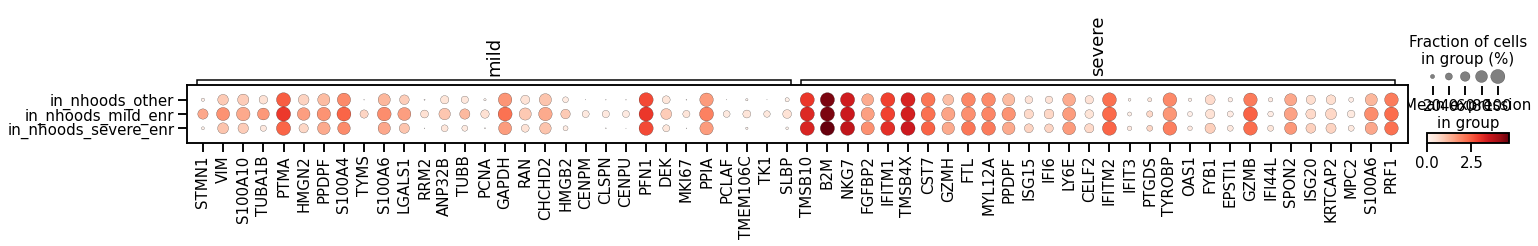

In [717]:
DE_df = pd.DataFrame(nk_adata.uns['rank_genes_groups']['names'])[0:30][['in_nhoods_mild_enr', 'in_nhoods_severe_enr']]
nk_adata.obs['nhood_groups'] = nk_adata.obs['nhood_groups'].cat.reorder_categories(['in_nhoods_other','in_nhoods_mild_enr', 'in_nhoods_severe_enr'])
sc.pl.dotplot(nk_adata, 
              {'mild':DE_df['in_nhoods_mild_enr'], 'severe':DE_df['in_nhoods_severe_enr']}, 
              groupby='nhood_groups')

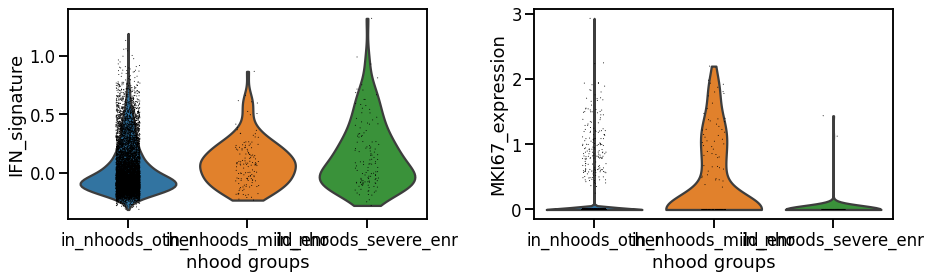

In [719]:
sc.pl.violin(nk_adata, 
             ['IFN_signature','MKI67_expression'], 
              groupby='nhood_groups')

In [661]:
## Run DE testing
DE_NK_severe = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'].isin(anno_groups['NK'])], 
    test_group='severe_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

DE_NK_mild = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'].isin(anno_groups['NK'])], 
    test_group='mild_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

In [662]:
## Save 
DE_NK_severe['contrast'] = 'severe_enr-other'
DE_NK_mild['contrast'] = 'mild_enr-other'
DE_NK = pd.concat([DE_NK_mild, DE_NK_severe])
DE_NK.to_csv(resdir + 'DEresults_NKNhoods.csv')

In [721]:
DE_NK[DE_NK['gene_name'].isin(ifn_signature_genes)]

pval  adj_pval  f_statistic  df1         df2       lfc  \
gene_name                                                               
IFI44L     0.485425  0.726582     0.487999    1  269.023945 -0.606760   
ISG15      0.512632  0.736501     0.429831    1  269.023945  0.254877   
IFI6       0.214977  0.472848     1.544870    1  269.023945  0.514283   
MX1        0.667237  0.837853     0.185259    1  269.023945  0.236860   
IFIT3      0.604565  0.799975     0.268799    1  269.023945  0.335207   
XAF1       0.295701  0.560743     1.097748    1  269.023945 -0.395286   
LY6E       0.013342  0.074413     6.205010    1  269.023945  0.380328   
EIF2AK2    0.856773  0.935924     0.032637    1  269.023945  0.068111   
OAS1       0.692561  0.852882     0.156663    1  269.023945  0.212323   
STAT1      0.878291  0.943179     0.023495    1  269.023945 -0.049211   
MX2        0.925597  0.967630     0.008737    1  269.023945  0.053619   
IRF7       0.995622  0.999806     0.000030    1  269.023945 -0.002184   
TRIM22     0.333186  0.595007     0.939856    1  269.023945 -0.258218   
SAMD9      0.833083  0.926431     0.044502    1  269.023945 -0.058445   
IFI35      0.667249  0.837853     0.185244    1  269.023945  0.133060   
EPSTI1     0.651270  0.829591     0.204761    1  269.023945  0.183212   
CMPK2      0.417439  0.669267     0.659545    1  269.023945  0.556336   
SP110      0.432858  0.682703     0.616994    1  269.023945 -0.173336   
PLSCR1     0.382537  0.638048     0.765036    1  269.023945  0.327850   
OAS2       0.435806  0.684333     0.609118    1  269.023945  0.318610   
PARP9      0.355495  0.614955     0.856696    1  269.023945  0.319185   
HERC5      0.141218  0.371277     2.177431    1  269.023945  0.548864   
SAMD9L     0.969924  0.987969     0.001424    1  269.023945  0.012418   
UBE2L6     0.810598  0.919004     0.057547    1  269.023945  0.043672   
IFI44L     0.379460  0.875922     0.775000    1  269.023945  0.768765   
ISG15      0.075840  0.678843     3.176327    1  269.023945  0.815154   
IFI6       0.069798  0.660971     3.314131    1  269.023945  0.918991   
MX1        0.386101  0.879011     0.753637    1  269.023945  0.593852   
IFIT3      0.007840  0.400261     7.176918    1  269.023945  1.714904   
XAF1       0.053531  0.640447     3.760233    1  269.023945  0.767177   
LY6E       0.015675  0.485784     5.913853    1  269.023945  0.458239   
EIF2AK2    0.066033  0.658329     3.406642    1  269.023945  0.803989   
OAS1       0.016537  0.496115     5.817516    1  269.023945  1.359581   
STAT1      0.125147  0.754170     2.366414    1  269.023945  0.583599   
MX2        0.532747  0.921334     0.390156    1  269.023945  0.450093   
IRF7       0.178006  0.797684     1.823720    1  269.023945  0.625923   
TRIM22     0.030799  0.574856     4.713615    1  269.023945  0.634019   
SAMD9      0.252427  0.829103     1.315461    1  269.023945  0.385584   
IFI35      0.867188  0.972769     0.028020    1  269.023945  0.071586   
EPSTI1     0.129961  0.762396     2.307063    1  269.023945  0.736713   
CMPK2      0.957974  0.991505     0.002782    1  269.023945  0.054747   
SP110      0.141778  0.766223     2.171287    1  269.023945  0.386648   
PLSCR1     0.503603  0.915262     0.448541    1  269.023945  0.340212   
OAS2       0.409480  0.885150     0.682439    1  269.023945  0.443618   
PARP9      0.631997  0.939620     0.229888    1  269.023945  0.231322   
HERC5      0.354373  0.875084     0.860704    1  269.023945  0.478227   
SAMD9L     0.307365  0.855870     1.045932    1  269.023945  0.417818   
UBE2L6     0.528070  0.920949     0.399141    1  269.023945  0.150170   

          gene_name          contrast  
gene_name                              
IFI44L       IFI44L    mild_enr-other  
ISG15         ISG15    mild_enr-other  
IFI6           IFI6    mild_enr-other  
MX1             MX1    mild_enr-other  
IFIT3         IFIT3    mild_enr-other  
XAF1           XAF1    mild_enr-other  
LY6E           LY6E    mild_enr-other  
EIF2

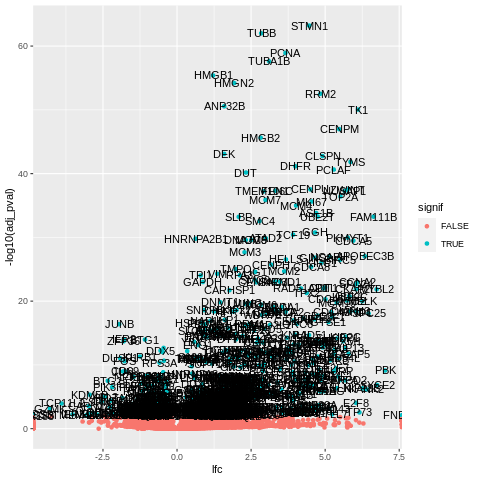

In [663]:
%%R -i DE_NK
max_lfc = 15
DE_NK$lfc <- ifelse(abs(DE_NK$lfc) > max_lfc, sign(DE_NK$lfc) * Inf, DE_NK$lfc)
DE_NK %>%
    filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.5), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

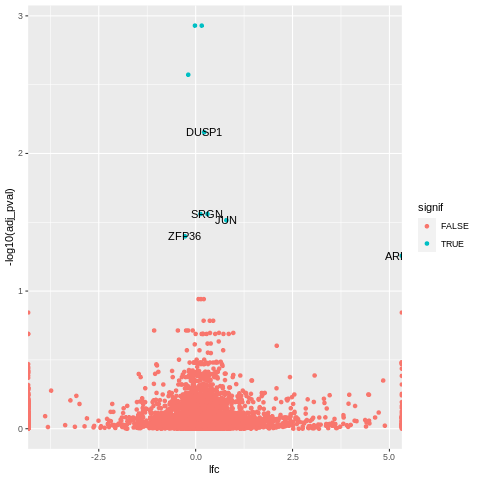

In [664]:
%%R -i DE_NK
max_lfc = 15
DE_NK$lfc <- ifelse(abs(DE_NK$lfc) > max_lfc, sign(DE_NK$lfc) * Inf, DE_NK$lfc)
DE_NK %>%
    filter(contrast == 'severe_enr-other') %>%
    mutate(signif = adj_pval < 0.1) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.2), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

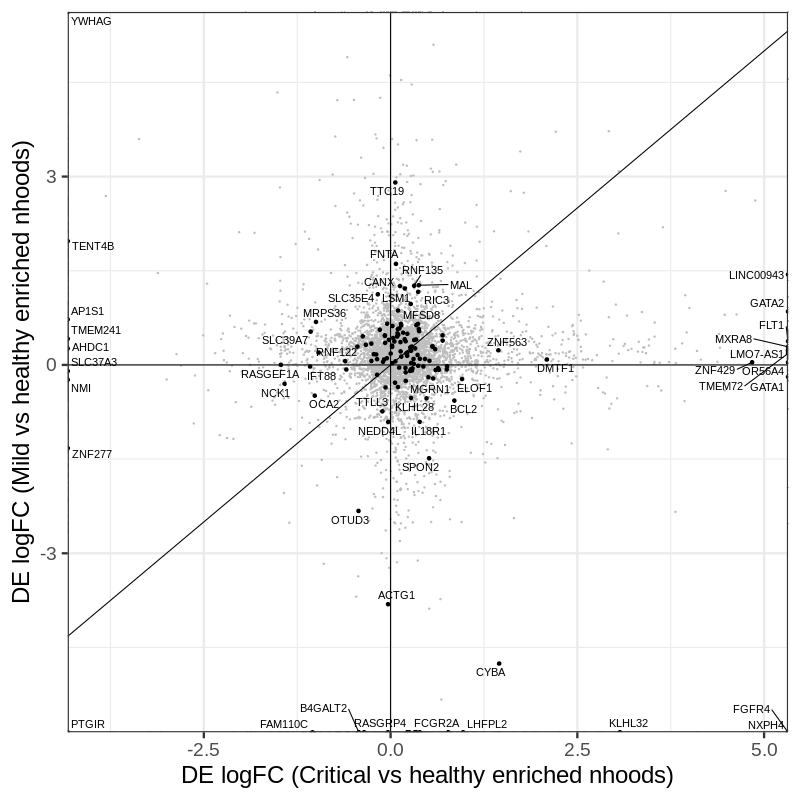

In [668]:
%%R -w 800 -h 800
DE_NK$lfc <- ifelse(abs(DE_NK$lfc) > max_lfc, sign(DE_NK$lfc) * Inf, DE_NK$lfc)
DE_NK %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_severe < 0.5) & (adj_pval_mild >= 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_severe, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

... storing 'nhood_groups' as categorical
... storing 'anno_group' as categorical


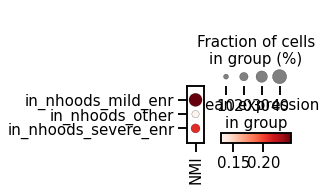

In [679]:
sc.pl.dotplot(adata[(adata.obs['author_cell_type'].isin(anno_groups['NK'])) & (adata.obs['severity_cont'] > 3)], 
              [ 'NMI'], groupby='nhood_groups')

### Low IFN and specific to advanced disease - Monos

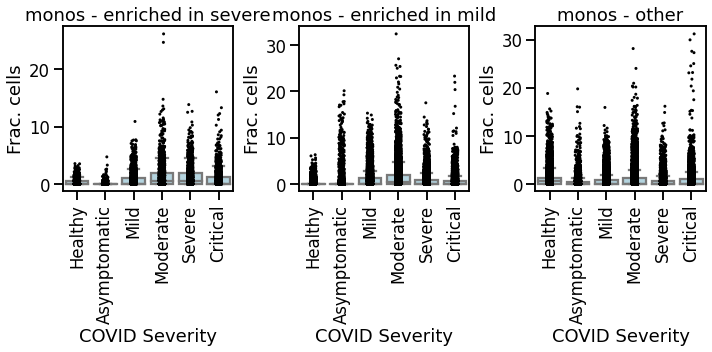

In [166]:
severe_monos_nhoods_all = FDR_df[((nhood_adata.obs['SpatialFDR_Critical'] < 0.1) | (nhood_adata.obs['SpatialFDR_Severe'] < 0.1)) &
       ((nhood_adata.obs['logFC_Critical'] > 0) & (nhood_adata.obs['logFC_Severe'] > 0)) &
      nhood_adata.obs['nhood_annotation'].isin(anno_groups['monos'])
      ].nhood_id.values

mild_monos_nhoods = FDR_df[((nhood_adata.obs['SpatialFDR_Asymptomatic'] < 0.1) | (nhood_adata.obs['SpatialFDR_Mild'] < 0.1) | (nhood_adata.obs['SpatialFDR_Moderate'] < 0.1)) &
       ((nhood_adata.obs['logFC_Asymptomatic'] > 0) & (nhood_adata.obs['logFC_Mild'] > 0) & (nhood_adata.obs['logFC_Moderate'] > 0)) &
      nhood_adata.obs['nhood_annotation'].isin(anno_groups['monos'])
      ].nhood_id.values

severe_monos_nhoods = np.setdiff1d(severe_monos_nhoods_all, mild_monos_nhoods)
other_monos_nhoods = np.setdiff1d(FDR_df[nhood_adata.obs['nhood_annotation'].isin(anno_groups['monos'])].nhood_id.values, np.union1d(severe_monos_nhoods, mild_monos_nhoods))


with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,3,1);
    plot_nhood_counts_by_severity(nhood_adata, severe_monos_nhoods, normalize=True);
    plt.title("monos - enriched in severe");
    plt.subplot(1,3,2);
    plot_nhood_counts_by_severity(nhood_adata, mild_monos_nhoods, normalize=True);
    plt.title("monos - enriched in mild")
    plt.subplot(1,3,3);
    plot_nhood_counts_by_severity(nhood_adata, other_monos_nhoods, normalize=True);
    plt.title("monos - other")
    plt.tight_layout()

In [167]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[mild_monos_nhoods, 'nhood_groups'] = 'mild_enr'
nhood_adata.obs.loc[severe_monos_nhoods, 'nhood_groups'] = 'severe_enr'
nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other'
adata.uns['nhood_adata'] = nhood_adata.copy()

In [172]:
## Run DE testing
DE_monos_severe = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'].isin(anno_groups['monos'])], 
    test_group='severe_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

DE_monos_mild = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'].isin(anno_groups['monos'])], 
    test_group='mild_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

In [727]:
## Save 
DE_monos_severe['contrast'] = 'severe_enr-other'
DE_monos_mild['contrast'] = 'mild_enr-other'
DE_monos = pd.concat([DE_monos_mild, DE_monos_severe])
DE_monos.to_csv(resdir + 'DEresults_monosNhoods.csv')

In [175]:
DE_monos = pd.read_csv(resdir + 'DEresults_monosNhoods.csv')

In [186]:
def assign_cells_2_nhood_group(
    adata, 
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    
    '''
    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

assign_cells_2_nhood_group(adata)
adata.obs['anno_group'] = [anno_group_rev[x] for x in adata.obs['author_cell_type']]

In [197]:
df = adata.obs[['nhood_groups', 'severity_cont','anno_group']]
df = df[df.anno_group == 'monos']
df = df.value_counts().reset_index().sort_values("severity_cont")
df.columns = ['nhood_groups', 'severity_cont','anno_group', 'n_cells']
df['severity'] = [order_severity[i] for i in df.severity_cont]

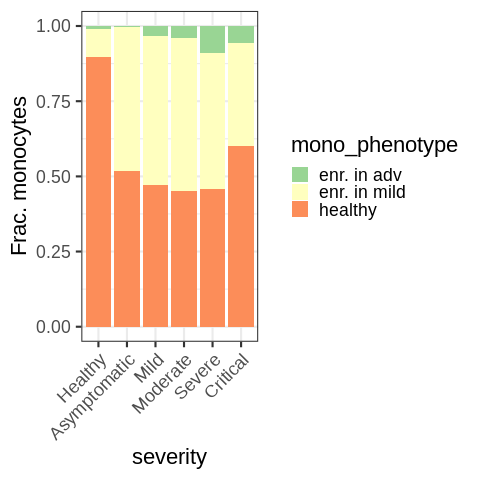

In [213]:
%%R -i df
df %>%
mutate(mono_phenotype = case_when(
    nhood_groups == 'in_nhoods_other' ~ 'healthy',
    nhood_groups == 'in_nhoods_severe_enr' ~ 'enr. in adv',
    nhood_groups == 'in_nhoods_mild_enr' ~ 'enr. in mild',
                                 )) %>%
mutate(severity = factor(severity, levels=unlist(order_severity))) %>%
ggplot(aes(severity, n_cells, fill=mono_phenotype)) +
geom_col(position='fill') +
theme_bw(base_size=22) +
ylab("Frac. monocytes") +
scale_fill_brewer(palette='Spectral', direction=-1) +
theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1))

... storing 'anno_group' as categorical


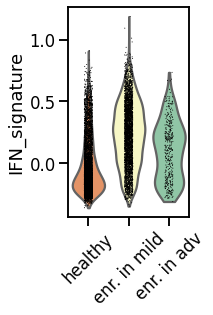

In [221]:
sns.set_context('talk')
adata.obs['nhood_groups']  = adata.obs['nhood_groups'].astype('category')
mono_pheno_dict = {
    'in_nhoods_mild_enr':'enr. in mild',
    'in_nhoods_severe_enr':'enr. in adv',
    'in_nhoods_other':'healthy'
}
adata.obs['mono_phenotype'] = np.nan
adata.obs.loc[~adata.obs['nhood_groups'].isna(), 'mono_phenotype'] = [mono_pheno_dict[x] if not x == np.nan else np.nan for x in adata.obs.loc[~adata.obs['nhood_groups'].isna(), 'nhood_groups']]
adata.obs['mono_phenotype'] = adata.obs['mono_phenotype'].astype('category').cat.reorder_categories(['healthy', 'enr. in mild', 'enr. in adv'])
with rc_context({'figure.figsize':[3,4]}):
    sc.pl.violin(adata[adata.obs['anno_group'] == 'monos'], 'IFN_signature', groupby='mono_phenotype', palette='Spectral', rotation=45)

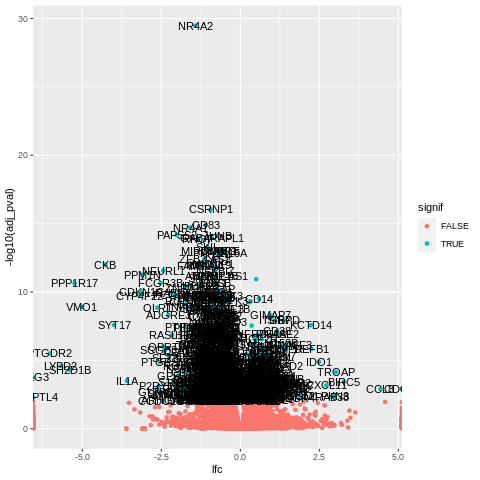

In [222]:
%%R -i DE_monos
max_lfc = 15
DE_monos$lfc <- ifelse(abs(DE_monos$lfc) > max_lfc, sign(DE_monos$lfc) * Inf, DE_monos$lfc)
DE_monos %>%
    filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.5), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

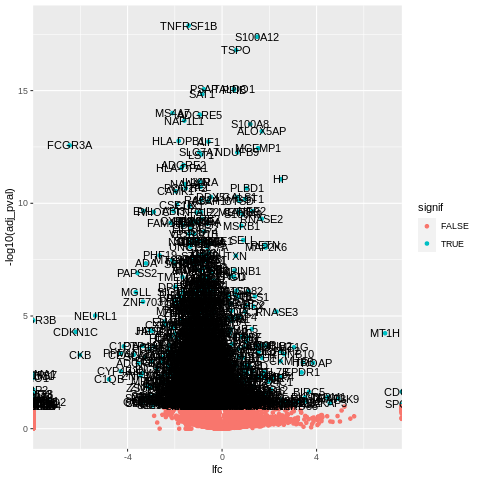

In [223]:
%%R 

DE_monos %>%
    filter(contrast == 'severe_enr-other') %>%
    mutate(signif = adj_pval < 0.1) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.2), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

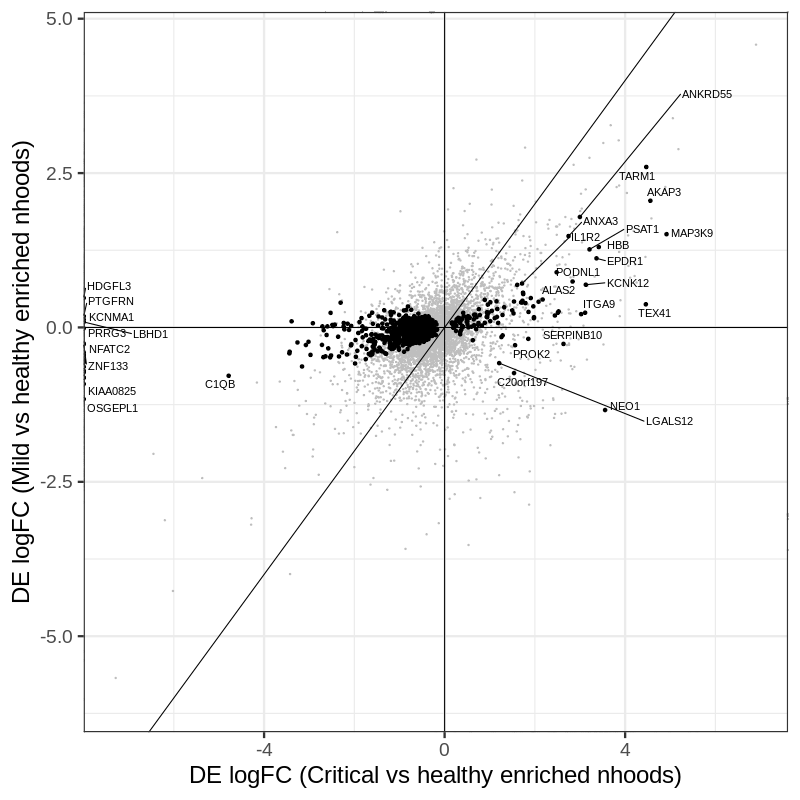

In [226]:
%%R -w 800 -h 800
DE_monos %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_severe < 0.1) & (adj_pval_mild >= 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_severe, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

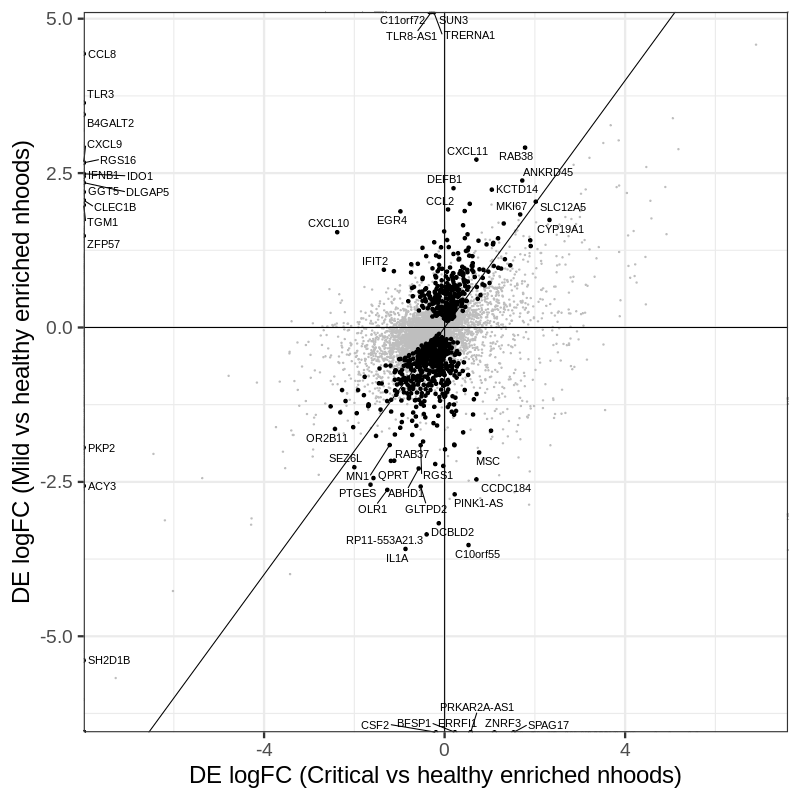

In [810]:
%%R -w 800 -h 800
DE_monos %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_severe >= 0.1) & (adj_pval_mild < 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_severe, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

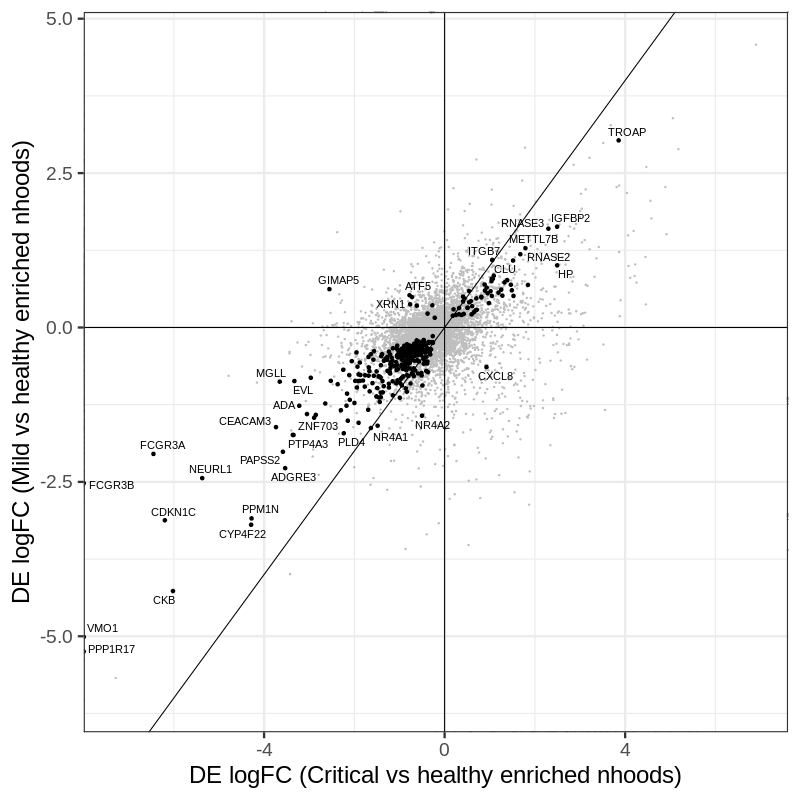

In [811]:
%%R -w 800 -h 800
DE_monos %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_severe < 0.01) & (adj_pval_mild < 0.01), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_severe, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

In [812]:
DE_monos[DE_monos.gene_name.isin(ifn_signature_genes)]

gene_name          pval  adj_pval  f_statistic  df1         df2  \
12        IFI6  2.286063e-05  0.000342    18.482745    1  316.371807   
15        LY6E  3.345536e-03  0.021090     8.740896    1  316.371807   
19       ISG15  8.764518e-05  0.001025    15.791489    1  316.371807   
27      IFI44L  7.627072e-04  0.006253    11.553692    1  316.371807   
31         MX1  1.260038e-04  0.001361    15.071795    1  316.371807   
94       IFIT3  6.556688e-07  0.000015    25.776397    1  316.371807   
101     UBE2L6  3.712892e-03  0.022840     8.545819    1  316.371807   
113       XAF1  6.049795e-05  0.000761    16.529678    1  316.371807   
123     EPSTI1  2.213206e-06  0.000045    23.250346    1  316.371807   
128       IRF7  4.131899e-05  0.000553    17.292327    1  316.371807   
134        MX2  2.275875e-05  0.000342    18.491758    1  316.371807   
135      STAT1  8.856376e-05  0.001034    15.770774    1  316.371807   
152      HERC5  1.378291e-06  0.000030    24.230445    1  316.371807   
176       OAS1  1.535402e-02  0.071755     5.939732    1  316.371807   
195       BST2  4.857724e-07  0.000012    26.403346    1  316.371807   
207      CMPK2  5.382274e-05  0.000692    16.763171    1  316.371807   
214     TRIM22  4.654546e-05  0.000609    17.053730    1  316.371807   
218     SAMD9L  3.600523e-07  0.000010    27.031033    1  316.371807   
222      IFI35  2.099034e-07  0.000006    28.166009    1  316.371807   
235       OAS2  1.023891e-06  0.000023    24.847716    1  316.371807   
262      SP110  2.825177e-03  0.018315     9.058396    1  316.371807   
271      PARP9  9.746802e-05  0.001122    15.580554    1  316.371807   
298      SAMD9  1.207402e-04  0.001312    15.156223    1  316.371807   
309    EIF2AK2  1.728888e-06  0.000036    23.760901    1  316.371807   
1067    PLSCR1  1.741484e-06  0.000036    23.745878    1  316.371807   
6631      IFI6  2.203435e-03  0.015834     9.527269    1  316.371807   
6634      LY6E  6.496302e-01  0.824933     0.206761    1  316.371807   
6638     ISG15  5.050129e-01  0.725251     0.445402    1  316.371807   
6646    IFI44L  8.993358e-01  0.957026     0.016028    1  316.371807   
6650       MX1  1.870168e-01  0.412759     1.748530    1  316.371807   
6713     IFIT3  3.694168e-01  0.617057     0.807929    1  316.371807   
6720    UBE2L6  4.587947e-01  0.693483     0.550179    1  316.371807   
6732      XAF1  8.128965e-01  0.913818     0.056116    1  316.371807   
6742    EPSTI1  9.138759e-01  0.963898     0.011715    1  316.371807   
6747      IRF7  9.222514e-01  0.967721     0.009541    1  316.371807   
6753       MX2  2.879146e-01  0.536038     1.133158    1  316.371807   
6754     STAT1  1.312376e-01  0.334744     2.289649    1  316.371807   
6771     HERC5  1.202689e-01  0.317662     2.426892    1  316.371807   
6795      OAS1  7.555736e-01  0.890002     0.097075    1  316.371807   
6814      BST2  1.059915e-02  0.056080     6.609728    1  316.371807   
6826     CMPK2  4.038611e-01  0.649771     0.698672    1  316.371807   
6833    TRIM22  3.384561e-02  0.131786     4.541893    1  316.371807   
6837    SAMD9L  6.516188e-01  0.826258     0.204254    1  316.371807   
6841     IFI35  2.727110e-01  0.518974     1.207259    1  316.371807   
6854      OAS2  3.578509e-01  0.606870     0.847892    1  316.371807   
6881     SP110  6.437281e-03  0.037707     7.523410    1  316.371807   
6890     PARP9  8.689637e-01  0.940978     0.027261    1  316.371807   
6917     SAMD9  2.097785e-01  0.441924     1.579370    1  316.371807   
6928   EIF2AK2  8.481186e-01  0.931976     0.036740    1  316.371807   
7686    PLSCR1  8.751406e-02  0.259371     2.937686    1  316.371807   

           lfc gene_name.1          contrast  
12    0.941129        IFI6    mild_enr-other  
15    0.528345        LY6E    mild_enr-other  
19    0.879585       ISG15    mild_enr-other  
27    0.903741      IFI44L    mild_enr-other  
31    0.870806         MX1    mild_enr-other  
94    1.155722       IFIT3    mild_enr-other  
101

In [814]:
DE_monos[DE_monos.gene_name.isin(['S100A8'])]

gene_name          pval      adj_pval  f_statistic  df1         df2  \
191     S100A8  5.990819e-06  1.060247e-04    21.203683    1  316.371807   
6810    S100A8  5.128422e-17  3.085911e-14    78.842283    1  316.371807   

           lfc gene_name.1          contrast  
191   0.563947      S100A8    mild_enr-other  
6810  1.194845      S100A8  severe_enr-other

#### Enrichment analysis

In [818]:
signif_severe = DE_monos.gene_name[(DE_monos.adj_pval < 0.1) & (DE_monos.contrast == 'severe_enr-other')].values
signif_mild = DE_monos.gene_name[(DE_monos.adj_pval < 0.1) & (DE_monos.contrast == 'mild_enr-other')].values

signif_both = np.intersect1d(signif_severe, signif_mild)
signif_severe_only = np.setdiff1d(signif_severe, signif_mild)
signif_mild_only = np.setdiff1d(signif_mild, signif_severe)

In [821]:
DE_monos.index = DE_monos.gene_name.copy()

In [822]:
enr_mild_up, enr_mild_down = run_enrichr(DE_monos[DE_monos.contrast == 'mild_enr-other'].loc[signif_mild_only], 
                                         min_lfc= 0,
                                         outdir = resdir + 'enrichr/Monos_mild/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:7e71d4bbd0d69e291acdd961ad93f685
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:c415ed53e35d7da70cd948877f1c0b36
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:eb926d2edac81d82088ab9a499238881
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:44932c7bc843abcc837d818b2115bdf7
Done.



In [823]:
enr_severe_up, enr_severe_down = run_enrichr(DE_monos[DE_monos.contrast == 'severe_enr-other'].loc[signif_severe_only], 
                                         min_lfc= 0,
                                         outdir = resdir + 'enrichr/Monos_severe/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:79a7fc21da24721617efa28e76d9251d
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:b6fcf4888240243fbd0b151368392cfb
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:94b9e241059c49c1b2846c83aa2b985c
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:8c92910cd7eab1dcdd3f635021482596
Done.



In [824]:
enr_severe_down[enr_severe_down['Adjusted P-value'] < 0.1]

Gene_set  \
0     GO_Biological_Process_2021   
1     GO_Biological_Process_2021   
2     GO_Biological_Process_2021   
3     GO_Biological_Process_2021   
4     GO_Biological_Process_2021   
...                          ...   
3324        MSigDB_Hallmark_2020   
3325        MSigDB_Hallmark_2020   
3326        MSigDB_Hallmark_2020   
3327        MSigDB_Hallmark_2020   
3328        MSigDB_Hallmark_2020   

                                                   Term  Overlap  \
0     interferon-gamma-mediated signaling pathway (G...    19/68   
1     cellular response to interferon-gamma (GO:0071...   23/121   
2     positive regulation of transcription, DNA-temp...  78/1183   
3     antigen receptor-mediated signaling pathway (G...   24/185   
4                          phosphorylation (GO:0016310)   37/400   
...                                                 ...      ...   
3324                           IL-6/JAK/STAT3 Signaling     9/87   
3325                              Inflammatory Response   15/200   
3326                                    Notch Signaling     5/32   
3327                                 Hedgehog Signaling     5/36   
3328                                     UV Response Up   12/158   

           P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     8.677024e-13      2.877301e-09            0                     0   
1     2.186827e-11      3.625759e-08            0                     0   
2     2.477086e-08      2.063339e-05            0                     0   
3     2.488950e-08      2.063339e-05            0                     0   
4     5.505328e-08      3.651133e-05            0                     0   
...            ...               ...          ...                   ...   
3324  3.037905e-03      1.620216e-02            0                     0   
3325  4.031524e-03      1.935131e-02            0                     0   
3326  4.451122e-03      1.942308e-02            0                     0   
3327  7.444147e-03      2.977659e-02            0                     0   
3328  8.667777e-03      3.200410e-02            0                     0   

      Odds Ratio  Combined Score  \
0      11.147670      309.603427   
1       6.770531      166.189343   
2       2.103321       36.836726   
3       4.292719       75.160451   
4       2.962176       49.512669   
...          ...             ...   
3324    3.263518       18.917267   
3325    2.300826       12.685859   
3326    5.220923       28.269203   
3327    4.546312       22.278416   
3328    2.326744       11.047711   

                                                  Genes  
0     CIITA;CAMK2D;HLA-DRB5;PRKCD;HLA-C;IFI30;HLA-F;...  
1     HLA-DRB5;CIITA;CAMK2D;PRKCD;HLA-C;IFI30;HLA-F;...  
2     KDM5A;TCERG1;CIITA;CCNK;PID1;SPI1;CCNT2;HNRNPU...  
3     MEF2C;HLA-DRB5;PLEKHA1;FBXW11;PRKCB;WAS;NFATC2...  
4     CAMK2D;ROCK1;PRKDC;LRRK2;PRKAG2;PIK3CD;STK4;RP...  
...                                                 ...  
3324  CSF3R;HAX1;TGFB1;IRF1;IL6ST;IL2RG;IL12RB1;MYD8...  
3325  MSR1;GABBR1;PTGIR;CSF3R;SLC31A2;IL15;SPHK1;RHO...  
3326                    NOTCH2;APH1A;LFNG;PSENEN;FBXW11  
3327                        TLE3;NRP2;DPYSL2;RASA1;MYH9  
3328  STK25;IRF1;PRKCD;AGO2;POLE3;PPT1;HNRNPU;DDX21;...  

[171 rows x 10 columns]

In [825]:
enr_severe_up[enr_severe_up['Adjusted P-value'] < 0.1]

Gene_set  \
0    GO_Biological_Process_2021   
1    GO_Biological_Process_2021   
2    GO_Biological_Process_2021   
3    GO_Biological_Process_2021   
4    GO_Biological_Process_2021   
5    GO_Biological_Process_2021   
906        MSigDB_Hallmark_2020   
907        MSigDB_Hallmark_2020   

                                                  Term Overlap       P-value  \
0                neutrophil degranulation (GO:0043312)  21/481  1.703783e-13   
1    neutrophil activation involved in immune respo...  21/485  1.999956e-13   
2            neutrophil mediated immunity (GO:0002446)  21/488  2.253196e-13   
3    negative regulation of programmed cell death (...   9/381  2.569423e-04   
4    negative regulation of peptidase activity (GO:...    4/63  4.019494e-04   
5    positive regulation of vesicle fusion (GO:0031...     2/7  6.182484e-04   
906                                       Adipogenesis   6/200  8.390458e-04   
907                                         Glycolysis   5/200  4.988662e-03   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0        6.804653e-11            0                     0    9.966536   
1        6.804653e-11            0                     0    9.878584   
2        6.804653e-11            0                     0    9.813608   
3        5.819743e-02            0                     0    4.675343   
4        7.283323e-02            0                     0   12.683722   
5        9.335551e-02            0                     0   73.648148   
906      2.768851e-02            0                     0    5.857256   
907      8.231291e-02            0                     0    4.809524   

     Combined Score                                              Genes  
0        293.023699  VAT1;SERPINB10;SERPINB1;ANXA2;ANXA3;PGAM1;HEXB...  
1        288.854546  VAT1;SERPINB10;SERPINB1;ANXA2;ANXA3;PGAM1;HEXB...  
2        285.784602  VAT1;SERPINB10;SERPINB1;ANXA2;ANXA3;PGAM1;HEXB...  
3         38.649469   ANXA1;AIFM2;BNIP1;PROK2;SPRY2;AZU1;NOL3;MPO;MTDH  
4         99.176364                   SERPINB10;SERPINB1;CSTA;SERPINB2  
5        544.158196                                        ANXA1;ANXA2  
906       41.488382                  COX8A;CD151;TALDO1;ITGA7;ETFB;FAH  
907       25.493302                        GYS1;LDHA;PGAM1;TALDO1;NOL3

In [826]:
enr_mild_up[enr_mild_up['Adjusted P-value'] < 0.1]

Gene_set  \
0     GO_Biological_Process_2021   
1     GO_Biological_Process_2021   
2     GO_Biological_Process_2021   
3     GO_Biological_Process_2021   
4     GO_Biological_Process_2021   
...                          ...   
2237        MSigDB_Hallmark_2020   
2238        MSigDB_Hallmark_2020   
2239        MSigDB_Hallmark_2020   
2240        MSigDB_Hallmark_2020   
2241        MSigDB_Hallmark_2020   

                                                   Term Overlap       P-value  \
0                defense response to virus (GO:0051607)  35/133  5.018327e-32   
1             defense response to symbiont (GO:0140546)  34/124  8.349206e-32   
2      cytokine-mediated signaling pathway (GO:0019221)  57/621  5.855269e-26   
3     negative regulation of viral process (GO:0048525)   24/70  2.097267e-25   
4     negative regulation of viral genome replicatio...   22/54  2.325083e-25   
...                                                 ...     ...           ...   
2237                                        E2F Targets   9/200  7.001939e-03   
2238                                     Myc Targets V1   9/200  7.001939e-03   
2239                    Reactive Oxygen Species Pathway    4/49  9.244871e-03   
2240                                  KRAS Signaling Up   8/200  2.042476e-02   
2241                                        Coagulation   6/138  2.960329e-02   

      Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0         9.292667e-29            0                     0   23.137417   
1         9.292667e-29            0                     0   24.403447   
2         4.344609e-23            0                     0    6.893636   
3         1.035127e-22            0                     0   32.699542   
4         1.035127e-22            0                     0   42.845437   
...                ...          ...                   ...         ...   
2237      2.531470e-02            0                     0    2.797344   
2238      2.531470e-02            0                     0    2.797344   
2239      3.103635e-02            0                     0    5.236703   
2240      6.399757e-02            0                     0    2.465932   
2241      8.695965e-02            0                     0    2.682093   

      Combined Score                                              Genes  
0        1667.505014  IFITM3;IFITM1;IFIT5;IFIT1;IFI44L;IFIT3;IFIT2;O...  
1        1746.324248  IFITM3;IFITM1;IFIT5;IFIT1;IFI44L;IFIT3;IFIT2;O...  
2         400.519360  IFITM3;IFITM1;IL1RN;CXCL9;ITGB2;IFIT5;IL27;IFI...  
3        1858.118492  IFITM3;IFITM1;RSAD2;IFNB1;STAT1;MX1;IFIT5;EIF2...  
4        2430.230507  IFITM3;IFITM1;RSAD2;IFNB1;MX1;IFIT5;EIF2AK2;IS...  
...              ...                                                ...  
2237       13.879212  TOP2A;PTTG1;MYC;ANP32E;NAA38;MKI67;DLGAP5;AURK...  
2238       13.879212  PSMA6;PSMA4;SSB;SNRPD1;MYC;SNRPG;CUL1;UBE2L3;NME1  
2239       24.527076                                NQO1;FES;PRDX1;GCLM  
2240        9.594960  CXCL10;CFH;RGS16;ITGB2;AMMECR1;PDCD1LG2;EPHB2;...  
2241        9.440618               CFH;S100A13;SERPING1;TIMP1;RAC1;CTSB  

[281 rows x 10 columns]

In [827]:
enr_mild_down[enr_mild_down['Adjusted P-value'] < 0.1]

Gene_set  \
0     GO_Biological_Process_2021   
1     GO_Biological_Process_2021   
2     GO_Biological_Process_2021   
3     GO_Biological_Process_2021   
4     GO_Biological_Process_2021   
...                          ...   
2998        MSigDB_Hallmark_2020   
2999        MSigDB_Hallmark_2020   
3000        MSigDB_Hallmark_2020   
3001        MSigDB_Hallmark_2020   
3002        MSigDB_Hallmark_2020   

                                                   Term  Overlap   P-value  \
0           regulation of fever generation (GO:0031620)      4/5  0.000002   
1          regulation of apoptotic process (GO:0042981)   41/742  0.000006   
2        peptidyl-serine dephosphorylation (GO:0070262)     5/14  0.000020   
3     positive regulation of transcription, DNA-temp...  55/1183  0.000026   
4     positive regulation of acute inflammatory resp...     5/15  0.000029   
...                                                 ...      ...       ...   
2998                                     UV Response Dn    8/144  0.036070   
2999                             Estrogen Response Late   10/200  0.038437   
3000                                         Complement   10/200  0.038437   
3001                                         Glycolysis   10/200  0.038437   
3002                    Reactive Oxygen Species Pathway     4/49  0.039069   

      Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0             0.006798            0                     0  149.807692   
1             0.009137            0                     0    2.273519   
2             0.014894            0                     0   20.838150   
3             0.014894            0                     0    1.907522   
4             0.014894            0                     0   18.753372   
...                ...          ...                   ...         ...   
2998          0.079836            0                     0    2.204742   
2999          0.079836            0                     0    1.974811   
3000          0.079836            0                     0    1.974811   
3001          0.079836            0                     0    1.974811   
3002          0.079836            0                     0    3.321538   

      Combined Score                                              Genes  
0        1946.125675                               IL1B;PTGS2;TNF;PTGES  
1          27.286719  USP36;PRR7;TFRC;ARL6IP1;FAF1;XIAP;TNF;SH3RF1;I...  
2         225.533588               PPP2CA;PPP1R15B;PPP3CA;DUSP1;PPP2R2D  
3          20.110705  THRA;SERPINE1;RASL11A;NRL;TNF;PPP3CA;LYL1;LBH;...  
4         195.773746                           IL1B;OSM;FFAR3;PTGS2;TNF  
...              ...                                                ...  
2998        7.324814  TGFBR3;YTHDC1;DUSP1;SERPINE1;BHLHE40;ID1;LDLR;...  
2999        6.435394  SLC7A5;XBP1;NXT1;ELOVL5;ID2;PPIF;FOS;SGK1;TOB1...  
3000        6.435394  EHD1;DUSP5;SERPINE1;FDX1;MAFF;PLAUR;OLR1;TNFAI...  
3001        6.435394  MDH2;FAM162A;CTH;SRD5A3;PKP2;PGK1;CXCR4;ANGPTL...  
3002       10.769867                              PRDX4;EGLN2;CAT;OXSR1  

[93 rows x 10 columns]

In [828]:
pl_genes = enr_severe_up.iloc[0]["Genes"].split(";")

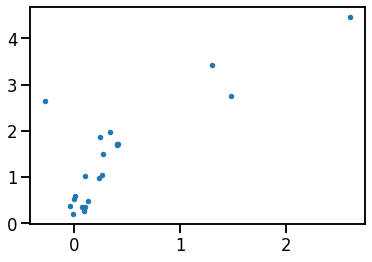

In [829]:
plt.plot(DE_monos.loc[(DE_monos.gene_name.isin(pl_genes)) & (DE_monos.contrast =='mild_enr-other')]['lfc'],
         DE_monos.loc[(DE_monos.gene_name.isin(pl_genes)) & (DE_monos.contrast =='severe_enr-other')]['lfc'],
         '.'
        );

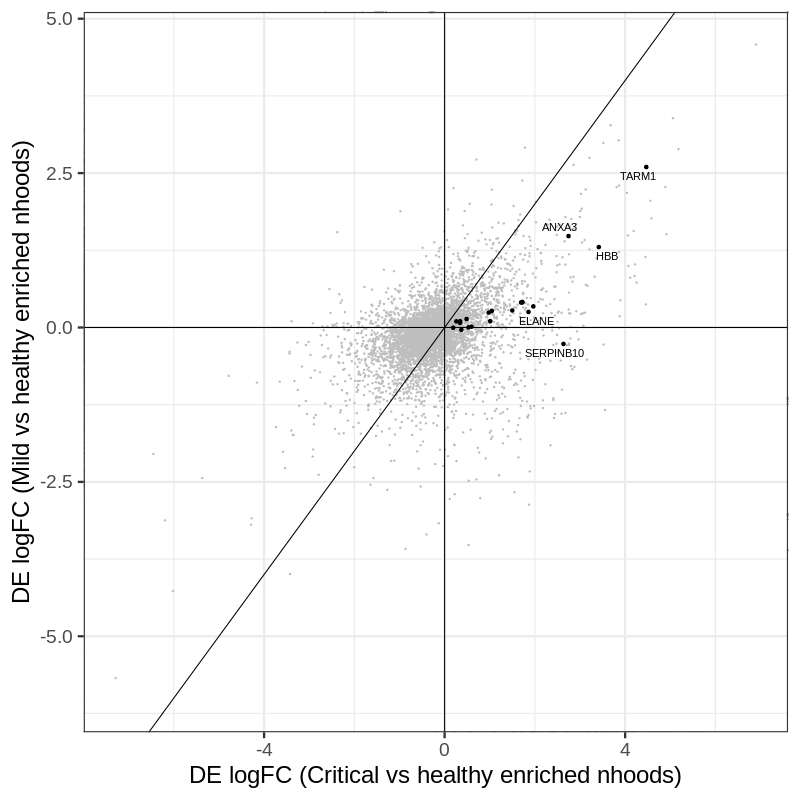

In [830]:
%%R -w 800 -h 800 -i pl_genes
DE_monos %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse(as.character(gene_name) %in% unlist(pl_genes), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_severe, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

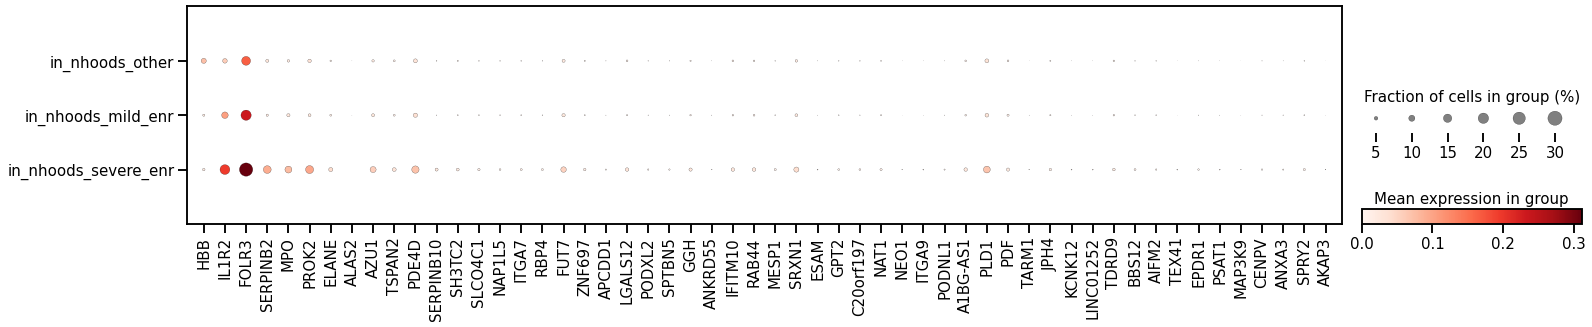

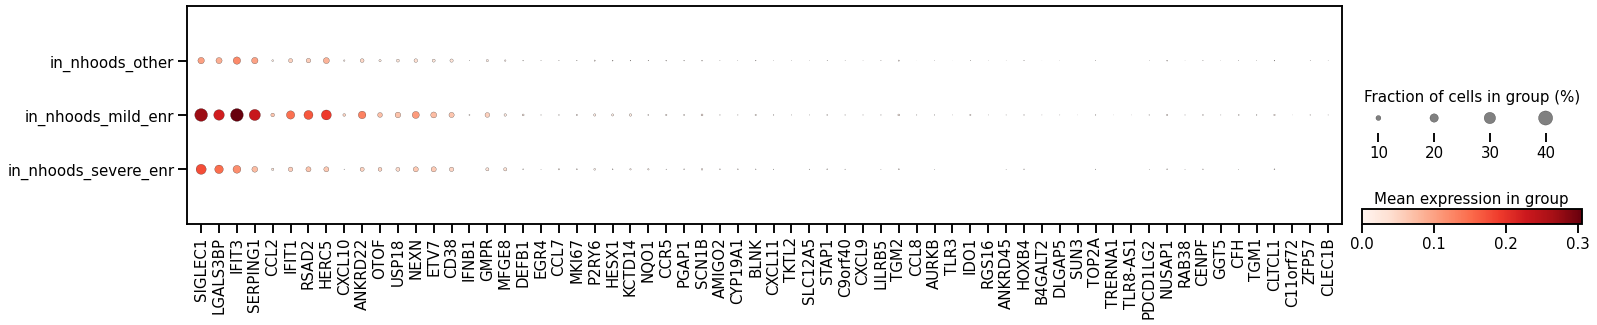

In [922]:
monos_adata = adata[adata.obs['author_cell_type'].isin(anno_groups['monos'])].copy()
monos_adata = monos_adata[~monos_adata.obs.nhood_groups.isna()].copy()
monos_adata.obs['nhood_groups'] = monos_adata.obs['nhood_groups'].cat.reorder_categories(['in_nhoods_other','in_nhoods_mild_enr', 'in_nhoods_severe_enr'])

df = DE_monos[(DE_monos.index.isin(signif_severe_only)) & (DE_monos.contrast == 'severe_enr-other')]
pl_genes = df.index[df.lfc > 1]
dp = sc.pl.dotplot(monos_adata, pl_genes, groupby='nhood_groups', return_fig=True, figsize=(25,4))
dp.legend(width=4, size_title = 'Fraction of cells in group (%)', colorbar_title = 'Mean expression in group').show()

df = DE_monos[(DE_monos.index.isin(signif_mild_only)) & (DE_monos.contrast == 'mild_enr-other')]
pl_genes = df.index[df.lfc > 1]
dp = sc.pl.dotplot(monos_adata, pl_genes, groupby='nhood_groups', return_fig=True, figsize=(25,4))
dp.legend(width=4, size_title = 'Fraction of cells in group (%)', colorbar_title = 'Mean expression in group').show()
# dp.legend(width=4).show()

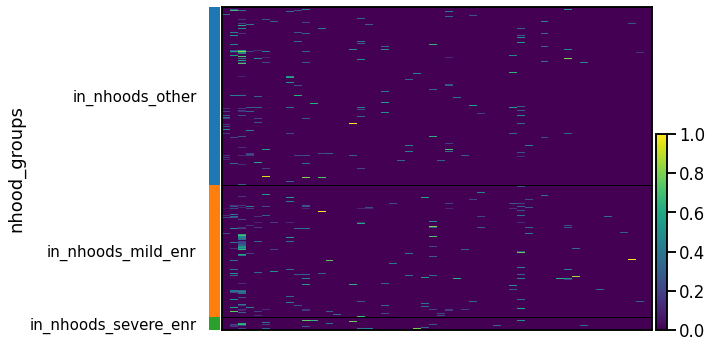

In [919]:
df = DE_monos[(DE_monos.index.isin(signif_severe_only)) & (DE_monos.contrast == 'severe_enr-other')]
pl_genes = df.index[df.lfc > 1]
sc.pl.heatmap(monos_adata, pl_genes, groupby='nhood_groups', standard_scale='var')

---
---
---

In [27]:
%%R -i cell_count_df
dim(cell_count_df)

[1] 593836      6


Joining, by = c("nhood_id", "nhood_annotation", "nhood_IFN_signature", "max_severity")
Joining, by = c("nhood_id", "nhood_annotation", "nhood_IFN_signature", "max_severity")


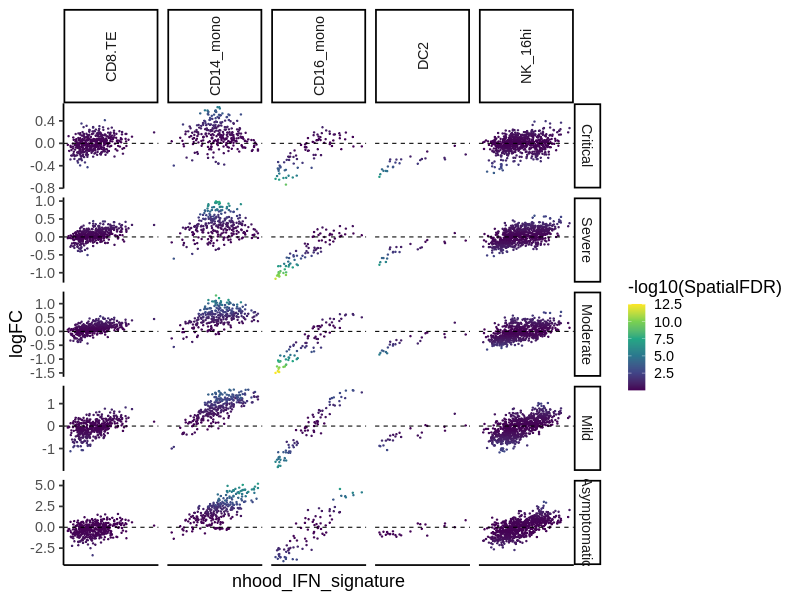

In [73]:
%%R -w 800 -h 600
min_max_scale <- function(x){
    x_scaled <- (x - min(x))/(max(x) - min(x))
    return(x_scaled)
}

keep_nhoods <- left_join(mutate(logFC_df, max_severity=str_remove(max_severity, "logFC_")),
          mutate(FDR_df, max_severity=str_remove(max_severity, "SpatialFDR_"))) %>%
    filter(nhood_annotation == 'CD16_mono' & logFC < -1) %>%
    pull(nhood_id) %>% unique()
    
# cell_count_df %>%
#     filter(nhood_id %in% keep_nhoods) %>%
#     ggplot(aes(as.factor(severity_cont), n_cells)) +
#     geom_boxplot(outlier.alpha=0) +
#     geom_jitter(size=0.1) 
    
left_join(mutate(logFC_df, max_severity=str_remove(max_severity, "logFC_")),
          mutate(FDR_df, max_severity=str_remove(max_severity, "SpatialFDR_"))) %>%
    mutate(max_severity=factor(max_severity, levels=order_severity)) %>%
    filter(nhood_annotation %in% c('NK_16hi', "CD8.TE", "CD14_mono", "CD16_mono", "DC2")) %>%
    group_by(max_severity) %>%
    mutate(scaled_logFC = scale(logFC)) %>%
    ungroup() %>%
    group_by(nhood_id) %>%
    mutate(mean_logFC = mean(scaled_logFC)) %>%
    mutate(cumsum = cumsum(sign(scaled_logFC))) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
#     mutate(nhood_id=factor(nhood_id, levels=nhood_order)) %>%
    mutate(nhood_id=factor(nhood_id, levels=unique(nhood_id))) %>%
    mutate(max_severity=factor(str_remove(max_severity, 'logFC_'), levels=rev(order_severity))) %>%
    ggplot(aes(nhood_IFN_signature, logFC, group=max_severity, color=-log10(SpatialFDR))) +
    geom_point(size=0.5) +
    facet_grid(max_severity~nhood_annotation, scales='free') +
    geom_hline(yintercept=0, linetype=2) +
    theme_classic(base_size=18) +
    scale_color_viridis_c() +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
         strip.text.x=element_text(angle=90)) 
#     ggplot(aes(max_severity, logFC, color=nhood_IFN_signature)) + geom_point()
    

Interesting observations:
- Not only increase of monocytes, but also significant low logFC 

In [ ]:
%%R
keep_nhoods <- left_join(mutate(logFC_df, max_severity=str_remove(max_severity, "logFC_")),
          mutate(FDR_df, max_severity=str_remove(max_severity, "SpatialFDR_"))) %>%
    filter(nhood_annotation == 'CD16_mono' & logFC < -1 & max_severity == '') %>%
    pull(nhood_id) %>% unique()
    
cell_count_df %>%
    filter(nhood_id %in% keep_nhoods) %>%
    ggplot(aes(as.factor(severity_cont), n_cells)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(size=0.1) 

Text(0.5, 1.0, 'CD14_mono')

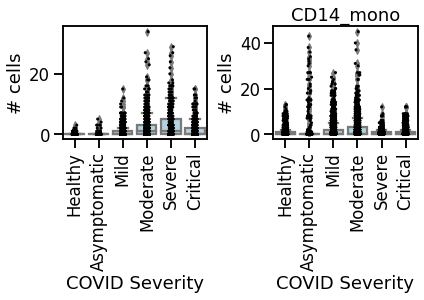

In [97]:
def plot_nhood_counts_by_severity(nhood_adata, n_ixs):
    pl_df = pd.DataFrame(nhood_adata[n_ixs].X.A, columns = nhood_adata.var_names).melt(var_name='sample_id', value_name='n_cells')
    pl_df = pd.merge(pl_df, nhood_adata.var)
    pl_df = pl_df[pl_df['severity_cont'] >= 0]
    pl_df['log_n_cells'] = np.log1p(pl_df['n_cells'])
    pl_df['severity_cont'] = [order_severity[i] for i in pl_df['severity_cont']]
    pl_df['severity_cont'] = pl_df['severity_cont'].astype('category').cat.reorder_categories(order_severity)
    sns.boxplot(data=pl_df, x='severity_cont', y='n_cells', color='lightblue');
    sns.stripplot(data=pl_df, x='severity_cont', y='n_cells', color='black', s=3);
    plt.xticks(rotation = 90); 
    plt.xlabel("COVID Severity"); plt.ylabel('# cells');

n_ixs = nhood_adata.obs_names[
    (nhood_adata.obs[ f'logFC_Critical'] > 0.5) & 
    (nhood_adata.obs['nhood_annotation'] == 'CD14_mono')
#                               & (nhood_adata.obs['logFC_severity_DAAsymptomatic-severity_DAHealthy'] > 2)
                             ]
plt.subplot(1,2,1);
plot_nhood_counts_by_severity(nhood_adata, n_ixs)

n_ixs = nhood_adata.obs_names[
    (nhood_adata.obs[ f'logFC_Asymptomatic'] > 0.5) & (nhood_adata.obs[ f'logFC_Severe'] < 0.1) &
    (nhood_adata.obs['nhood_annotation'] == 'CD14_mono')]
plt.subplot(1,2,2);
plot_nhood_counts_by_severity(nhood_adata, n_ixs);
plt.tight_layout();
plt.title('CD14_mono')

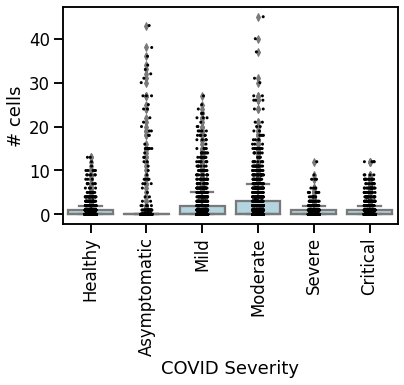